In [ ]:
# This notebook is for generating results for all subjects with cross-validation, and saving necessary variables for mapping

In [5]:
# load necessary libraries

# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2

import os, time
# select GPU for training
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# import tensorflow.experimental.numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import random
import scipy.io as scio
from scipy.io import savemat
import h5py 
import math

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)
    
import sys
sys.path.append("../../")
import lib
from lib.proc import *
from lib.simu import *
from lib.commons import *
from lib.net import *

import matplotlib.pyplot as plt
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
"""
hyper parameters
"""
LENGTH = 130
reg = 1e-2
prefix = "T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len%s-RoQ-XAIFinput-inference"%(str(LENGTH))
ISTRAIN = False
sample_pattern = 'RES01'
# parameters to set
DCE_DIM = 360
INIT_DIM = 4

OUT_DIM = LENGTH
IN_DIM = OUT_DIM
PK_DIM = 2

BATCH_SIZE = 1 # 
LR_RATE = 1e-3

BUFFER_SIZE = 8*BATCH_SIZE  # buffer size for shuffle
N_EPOCHS = 200
CKPT_PERIOD = 1

LAYER_NUM = 4
FEATURE_NUM = 64

hct=0.4

print(prefix)

T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len130-RoQ-XAIFinput-inference


In [7]:
# import multiprocessing as mp
from scipy.optimize import least_squares
import logging

logging.basicConfig(level=logging.INFO, format='%(processName)s: %(message)s')

def least_squares_optimization(c_pl, c_pan, x0, ind, mode, del_t):
    c_pl_use = c_pl
    c_pan_use = c_pan

    def fun_to_fit_VARPRO(x):
        return fun_oritofts_VARPRO(c_pl_use, c_pan_use[ind,:], x, del_t=del_t)

    result = least_squares(fun_to_fit_VARPRO, x0=x0, bounds=((1e-4), (0.4)))
    temp = g_VARPRO(c_pl_use, c_pan_use[ind,:], result.x, del_t = del_t)

    residual = tf.reduce_mean((fun_to_fit_VARPRO(result.x))**2).numpy()
    pfit = np.array([temp, result.x[0], temp/result.x[0], time.time()-timenow, residual]).reshape(1, 5)
    
    logging.info(f'Finished optimization for index {ind} in mode {mode}')

    return pfit

def fit_pred_test_pk_parallel(c_pl_pred, c_pan_pred, del_t=None): 
    numel = c_pan_pred.shape[0]
    pfit_pred = []
    pool = mp.Pool(mp.cpu_count())  # create a pool of processes

    results_pred = pool.starmap(least_squares_optimization, [(c_pl_pred, c_pan_pred, np.array([0.01]), ind, "pred", del_t) for ind in range(numel)])

    pool.close()  # close the pool
    pool.join()   # wait for all processes to finish

    for res in results_pred:
        if res is not None:
            pfit_pred.append(res)
            
    pfit_pred = np.concatenate(pfit_pred, axis=0) if pfit_pred else np.zeros((numel,5))
    print(pfit_pred[0:3])
    return pfit_pred



# use GT to get pk from pretrained and from VARPRO 
def fit_pred_test_pk(c_pl_pred, c_pan_pred, del_t=None): 
    from scipy.optimize import least_squares
    numel = c_pan_pred.shape[0]
    pfit_pred = np.zeros((0,5))
    for ind in range(numel):
#         try:
        def fun_to_fit_VARPRO(x):
            return fun_oritofts_VARPRO(c_pl_pred[ind,:], c_pan_pred[ind,:],x,del_t=del_t)

        timenow = time.time()
        if ind%100==0: print(f"Start fitting for prediction index: {ind}") 
        result = least_squares(fun_to_fit_VARPRO, x0 = np.array([0.01]),bounds=((1e-4),(1)))
        temp = g_VARPRO(c_pl_pred[ind,:],c_pan_pred[ind,:],result.x,del_t=del_t)

        residual = tf.reduce_mean((fun_to_fit_VARPRO(result.x))**2).numpy()
        pfit_pred = np.append(pfit_pred,np.array([60*temp,60*result.x[0],temp/result.x[0],time.time()-timenow,residual]).reshape(1,5),axis=0)
        if ind%100==0: print(f"Finished fitting for prediction index: {ind}") 
#         except:
#             print(f"An error occurred in fitting index: {ind}")
#             continue
    return pfit_pred


def permute_tf_tensor(t):

    # Create a tensor that represents the new order of your columns
    indices = tf.constant([2, 0, 1])

    # Use tf.gather to rearrange the columns of your tensor
    t_permuted = tf.gather(t, indices, axis=1)

    # Create a scaling vector
    scaling_vector = tf.constant([60.0, 60.0, 1.0])

    # Scale your tensor
    t_scaled = t_permuted * scaling_vector

    return t_scaled.numpy()

import numpy as np
from scipy.interpolate import interp1d

def interpolate_array(a):
    b = np.zeros_like(a, dtype=float)
    for i in range(a.shape[0]):
        if a[i,0] == 0:
            nonzero_indices = np.r_[0, np.nonzero(a[i,1:])[0] + 1]
            nonzero_values = a[i, nonzero_indices]
        else:
            nonzero_indices = np.nonzero(a[i])[0]
            nonzero_values = a[i, nonzero_indices]

        f = interp1d(nonzero_indices, nonzero_values, bounds_error=False, fill_value="extrapolate")
        b[i] = f(np.arange(a.shape[1]))

    return b

def flat_array(a):
    b = np.zeros_like(a, dtype=float)
    for i in range(a.shape[0]):
        b[i] = np.fmax.accumulate(a[i])
    return b

def filter_output(arr,ktrt=12,kept=24,vet=0.8,mask=None):
    """
    pretrained network uses certain range of parameters
    """
    if mask is None:
        # Create a mask using your conditions
        mask = (arr[:, 0] < ktrt) & (arr[:, 1] < kept) & (arr[:, 2] < vet)
        return arr[mask,:],mask
    else:
        return arr[mask,:]

def compute_nrmse(array1, array2):
    rmse = np.sqrt(np.mean((array1 - array2)**2))
    min_val = np.min(array1)
    max_val = np.max(array1)
    nrmse = rmse / (max_val - min_val)
    return nrmse

def gen_inp(C_ts,C_bd):
    C_ts_lbl=C_ts
    C_bd =  np.mean(C_bd,axis=0,keepdims=True)/(1-hct)
    C_bd_lbl =  C_bd
    norm_constant = np.max(C_bd_lbl)*(1-hct)

    # generate downsampled R1
    C_ts_ds,C_ts,bundle = gen_ds_R1(C_ts,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    # generate blood input 
    C_bd_ds,C_bd,bundle = gen_ds_R1(C_bd,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    # clip label 
    _,C_ts_lbl,_ = gen_ds_R1(C_ts_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    _,C_bd_lbl,_ = gen_ds_R1(C_bd_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    # generate spike
    C_ts_itnpl = gen_inge_spike(C_ts_ds,bundle,OUT_DIM=OUT_DIM)
    C_bd_itnpl = gen_inge_spike(C_bd_ds,bundle,OUT_DIM=OUT_DIM)
    bd_temp = np.repeat(C_bd_itnpl.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
    bd_temp2 = np.repeat(C_bd_lbl.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
    
    X_valid_ts = C_ts_itnpl/norm_constant
    Y_valid_ts = C_ts_lbl/norm_constant
    X_valid_pl = bd_temp/norm_constant
    Y_valid_pl = bd_temp2/norm_constant
    
    return X_valid_ts,X_valid_pl,Y_valid_ts,Y_valid_pl

In [8]:
# load models 

model_deconv = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Deconv_dense_fast_pancreas_checkparams.h5')
# ----------- construct model -----------
import datetime
from tensorflow.keras.regularizers import l2


tis_inp = tf.keras.Input(shape=(IN_DIM), name="tissue_ds")
bd_inp = tf.keras.Input(shape=(IN_DIM), name="aorta_fs")

with tf.name_scope("upsample"):
    x2 = tf.keras.layers.Dense(units=IN_DIM)(tis_inp)
    x2 = tf.keras.layers.Dense(units=IN_DIM,activation='relu')(x2)
    f_ts = tf.keras.layers.Dense(units=IN_DIM,name="Tissue",activation='relu')(x2)
with tf.name_scope("upsample2"):
    x3 = tf.keras.layers.Dense(units=IN_DIM)(bd_inp)
    x3 = tf.keras.layers.Dense(units=IN_DIM,activation='relu')(x3)
    f_bd = tf.keras.layers.Dense(units=IN_DIM,name="AIF",activation='relu')(x3)
    
model_upsample = tf.keras.Model(
    inputs=[tis_inp,bd_inp], outputs=[f_ts,f_bd]
)

model_upsample.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR_RATE),loss=tf.keras.losses.MeanSquaredError())
model_upsample.add_loss(DCloss_mag(f_ts, tis_inp,reg=0.1))
model_upsample.add_loss(DCloss_mag(f_bd, bd_inp,reg=0.1))

In [46]:
Y_pred_pan, Y_test_pan = np.zeros([0,3]),np.zeros([0,3])
Y_pred_tum,Y_test_tum = np.zeros([0,3]),np.zeros([0,3])
Y_pred_nontum,Y_test_nontum = np.zeros([0,3]),np.zeros([0,3])
Y_pred_pancreatitis,Y_test_pancreatitis = np.zeros([0,3]),np.zeros([0,3])
Y_pred_contrast,Y_test_contrast = np.zeros([0,3]),np.zeros([0,3])

for CV_SP in range(10):
    prefix_cv = "T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len%s-CV%s-RoQ-XAIFinput"%(str(LENGTH),str(CV_SP))
    """
    load data
    """
    mainfolder = "/hdd1/chaowei/data/dce/pancreas_syn_purified_linCA_wt_bdTK_VARPRO/"
    train_ind,test_ind = get_train_test_index(CV_SP,10)
    print('Processing fold:',test_ind)
    
    """
    load weights
    """
    checkpoint_path = os.path.join("/hdd1/chaowei/dce-dl/checkpoint/T1W-XAIFinp",prefix_cv,"cp-{epoch:04d}.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)

    model_upsample.load_weights(tf.train.latest_checkpoint(os.path.abspath(checkpoint_dir))).assert_existing_objects_matched()
#     model_upsample = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Upsample_XAIF_wt_constraint_pancreas_cv00.h5')
    model_upsample.trainable = False

    """
    start testing
    """
    print('Start testing...')
    test_folder = os.path.join(mainfolder,str(CV_SP))
    test_id =os.listdir(test_folder)
    for i in range(len(test_id)): 
        h5file = h5py.File(os.path.join(test_folder,test_id[i]),'r')
        print('processing:',os.path.join(test_id[i])) 
        if test_id[i][0:2] == 'HP': #health vol, all pan
            c_pl = np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)
            c_pan =  np.concatenate((np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0),
                                     np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
            num_pan = (np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0)).shape[0]
            c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp(c_pan,c_pl)
            c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
            c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
            c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)
            
            Y_pred_pan = np.append(Y_pred_pan,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred}))),axis=0)
            Y_test_pan = np.append(Y_test_pan,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds}))),axis=0)
            
        if test_id[i][0:2] == 'PD':
            if test_id[i][-7:-4] == 'pan':
                c_pl = np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)
                c_pan =  np.concatenate((np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0),
                                         np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
                num_pan = (np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0)).shape[0]
                c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp(c_pan,c_pl)
                c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
                c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
                c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)

                Y_pred_nontum = np.append(Y_pred_nontum,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred}))),axis=0)
                Y_test_nontum = np.append(Y_test_nontum,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds}))),axis=0)
                
            if test_id[i][-7:-4] == 'tum':
                c_pl = np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)
                c_pan =  np.concatenate((np.array(h5file['c_tum'],dtype=np.float32).transpose(1,0),
                                         np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
                num_pan = (np.array(h5file['c_tum'],dtype=np.float32).transpose(1,0)).shape[0]
                c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp(c_pan,c_pl)
                c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
                c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
                c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)

                Y_pred_tum = np.append(Y_pred_tum,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred}))),axis=0)
                Y_test_tum = np.append(Y_test_tum,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds}))),axis=0)
                
            if test_id[i][-7:-4] == 'oth':
                c_pl = np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)
                c_pan =  np.concatenate((np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0),
                                         np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
                num_pan = (np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0)).shape[0]
                c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp(c_pan,c_pl)
                c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
                c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
                c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)

                _y_pred_nontum = (permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred})))
                _y_test_nontum = (permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds})))
                Y_pred_nontum = np.append(Y_pred_nontum,_y_pred_nontum,axis=0)
                Y_test_nontum = np.append(Y_test_nontum,_y_test_nontum,axis=0)

                c_pl = np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)
                c_pan =  np.concatenate((np.array(h5file['c_tum'],dtype=np.float32).transpose(1,0),
                                         np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
                num_pan = (np.array(h5file['c_tum'],dtype=np.float32).transpose(1,0)).shape[0]
                c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp(c_pan,c_pl)
                c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
                c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
                c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)

                _y_pred_tum =(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred})))
                _y_test_tum = (permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds})))
                Y_pred_tum = np.append(Y_pred_tum,_y_pred_tum,axis=0)
                Y_test_tum = np.append(Y_test_tum,_y_test_tum,axis=0)
                
                Y_pred_contrast = np.append(Y_pred_contrast,abs(np.mean(_y_pred_tum,axis=0,keepdims=True)-np.mean(_y_pred_nontum,axis=0,keepdims=True)),axis=0)
                Y_test_contrast = np.append(Y_test_contrast,abs(np.mean(_y_test_tum,axis=0,keepdims=True)-np.mean(_y_test_nontum,axis=0,keepdims=True)),axis=0)
                
        if test_id[i][0:2] == 'PS': #pancreatisis
            c_pl = np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)
            c_pan =  np.concatenate((np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0),
                                     np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
            num_pan = (np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0)).shape[0]
            c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp(c_pan,c_pl)
            c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
            c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
            c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)

            Y_pred_pancreatitis = np.append(Y_pred_pancreatitis,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred}))),axis=0)
            Y_test_pancreatitis = np.append(Y_test_pancreatitis,(permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds}))),axis=0)
                
_dir = os.path.join("/hdd1/chaowei/dce-dl/result/",prefix)
smart_mkdir(_dir)
savemat(os.path.join(_dir,"Pan_Tum_bd_in_ts_model.mat" ),{"Y_pred_pan":Y_pred_pan,"Y_pred_tum":Y_pred_tum,"Y_pred_nontum":Y_pred_nontum,"Y_pred_pancreatitis":Y_pred_pancreatitis,
                                          "Y_test_pan":Y_test_pan,"Y_test_tum":Y_test_tum,"Y_test_nontum":Y_test_nontum,"Y_test_pancreatitis":Y_test_pancreatitis})
print('Finished Prediction.')



Processing fold: 0
Start testing...
processing: HP_0504_z21_pan.mat
processing: HP_2245_z25_pan.mat
processing: PD_0205_z19_pan.mat
processing: HP_0504_z18_pan.mat
processing: PS_2204_z19_pan.mat
processing: PD_0205_z33_both.mat
processing: PS_2204_z23_pan.mat
processing: PS_2204_z26_pan.mat
processing: PS_2204_z24_pan.mat
processing: HP_2245_z29_pan.mat
processing: HP_0504_z22_pan.mat
Processing fold: 1
Start testing...
processing: HP_0508_z16_pan.mat
processing: PS_2216_z36_pan.mat
processing: HP_0522_z18_pan.mat
processing: PS_2216_z32_pan.mat
processing: PD_2084_z23_tum.mat
processing: PD_2084_z15_pan.mat
processing: PS_2216_z34_pan.mat
processing: HP_0522_z16_pan.mat
processing: PS_2216_z33_pan.mat
processing: HP_0508_z23_pan.mat
processing: PD_2084_z21_tum.mat
processing: HP_0522_z15_pan.mat
processing: PS_2216_z35_pan.mat
Processing fold: 2
Start testing...
processing: PD_2127_z18_tum.mat
processing: PS_2250_z25_pan.mat
processing: HP_1002_z31_pan.mat
processing: HP_1002_z34_pan

Ktrans analysis: mean, std
Ctl: M2.58 S1.10
Tum: M0.91 S0.76
Non-tum: M1.90 S1.42
Pancreatitis: M2.13 S1.34
Contrast: M1.08 S0.78
kep analysis: mean, std
Ctl: M14.90 S5.23
Tum: M3.30 S1.78
Non-tum: M9.10 S5.99
Pancreatitis: M10.37 S4.75
Contrast: M7.02 S4.49
Ve analysis: mean, std
Ctl: M0.19 S0.06
Tum: M0.29 S0.09
Non-tum: M0.24 S0.09
Pancreatitis: M0.23 S0.11
Contrast: M0.08 S0.05
Ktrans analysis: T-test
Ttest_indResult(statistic=5.8726843348557916, pvalue=1.31244863849382e-07)
Ttest_indResult(statistic=2.2369898839984725, pvalue=0.028218595770677205)
Ttest_indResult(statistic=1.5135284135584783, pvalue=0.13429321684126297)
Ttest_indResult(statistic=-2.617649525752297, pvalue=0.012439478307065556)
kep analysis: T-test
Ttest_indResult(statistic=9.108173091321321, pvalue=1.6752001046823523e-13)
Ttest_indResult(statistic=4.261213660106171, pvalue=5.767797998166287e-05)
Ttest_indResult(statistic=3.582981361233853, pvalue=0.0005970374454119956)
Ttest_indResult(statistic=-3.8859130745981982

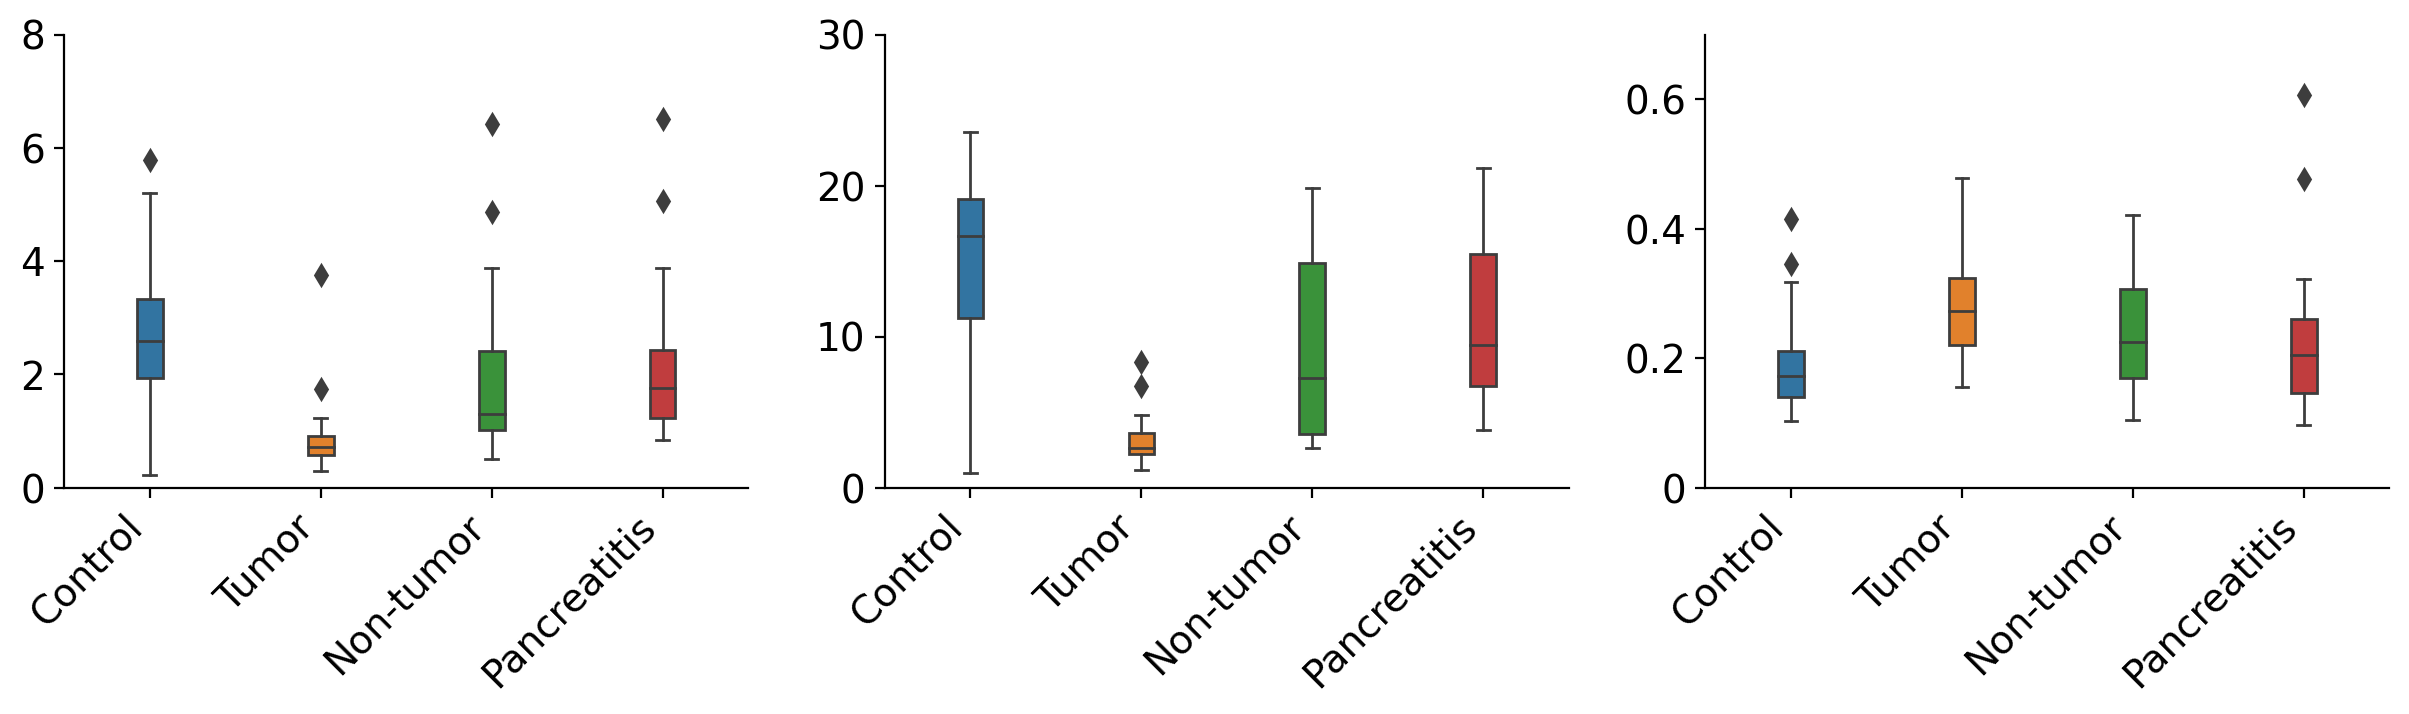

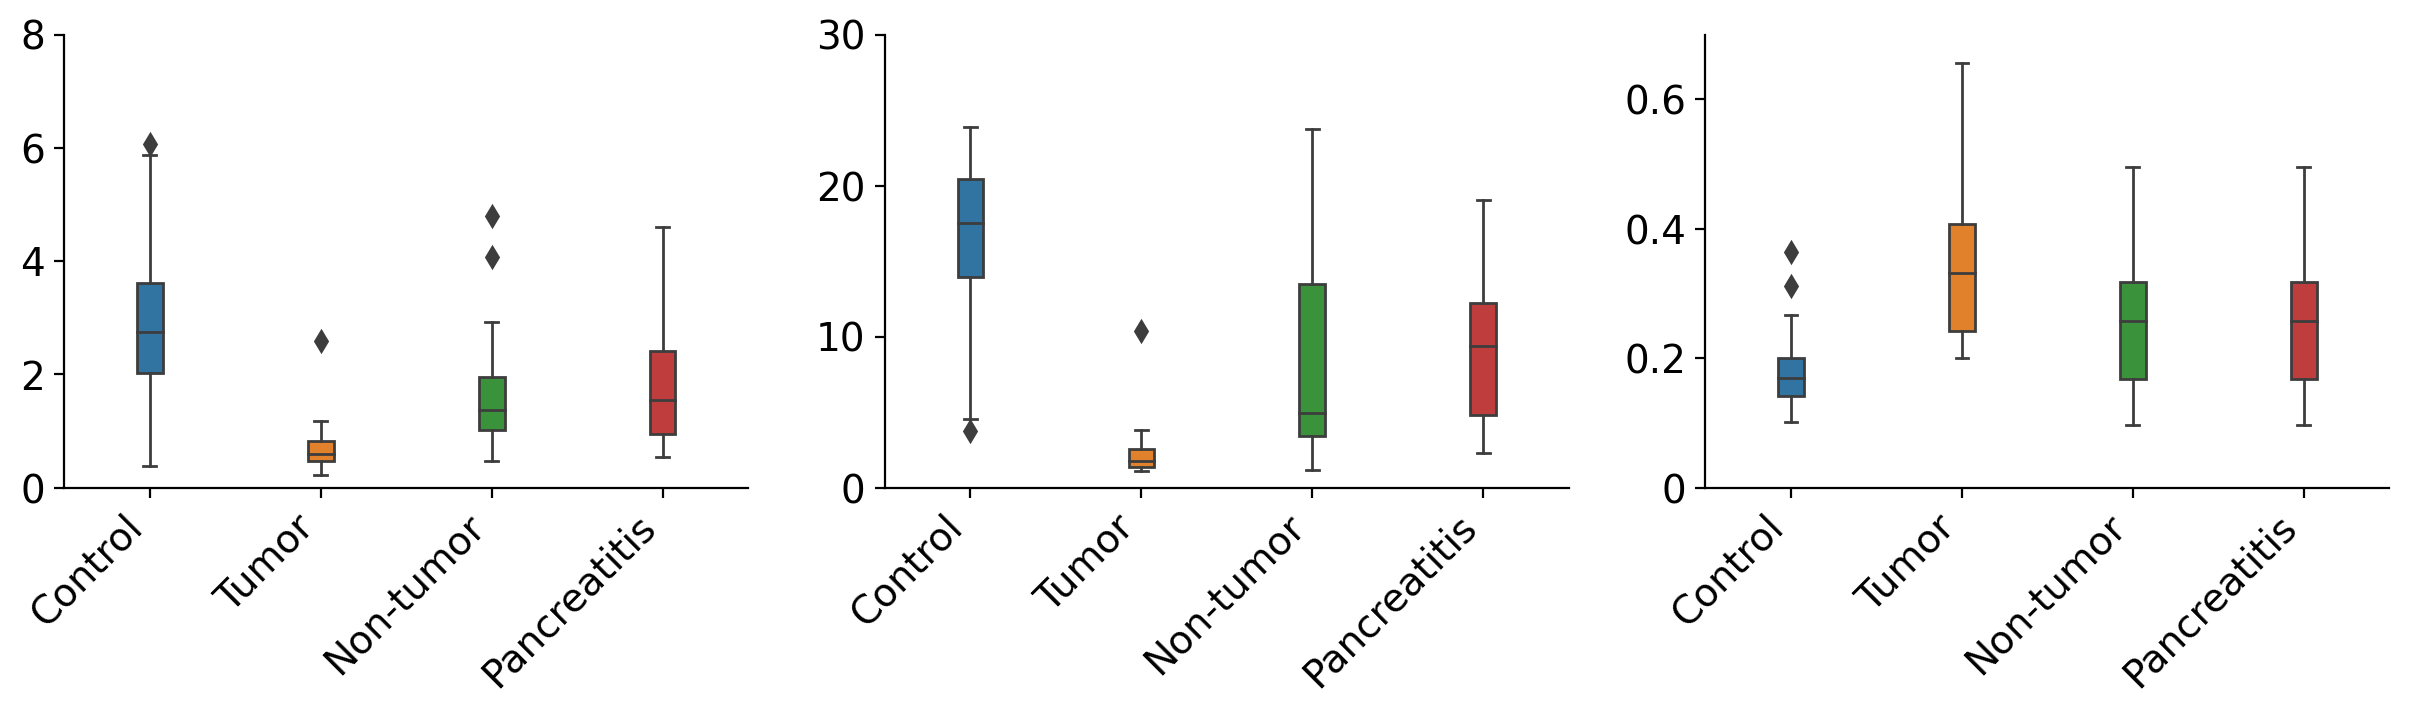

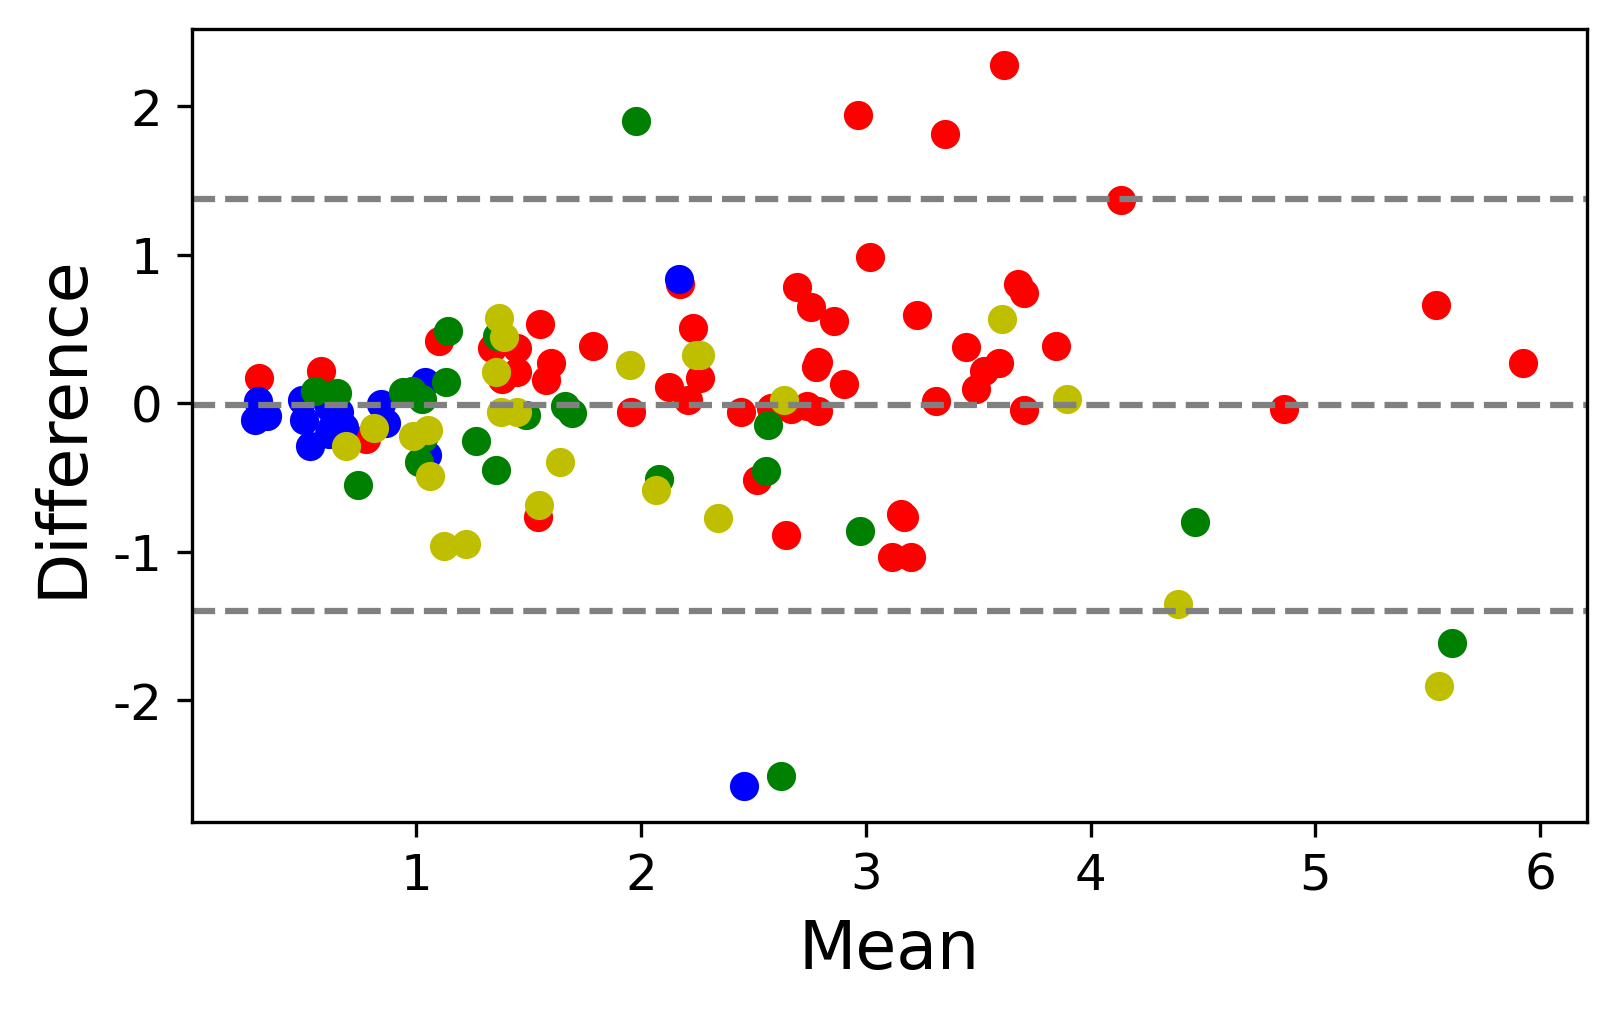

<Figure size 432x288 with 0 Axes>

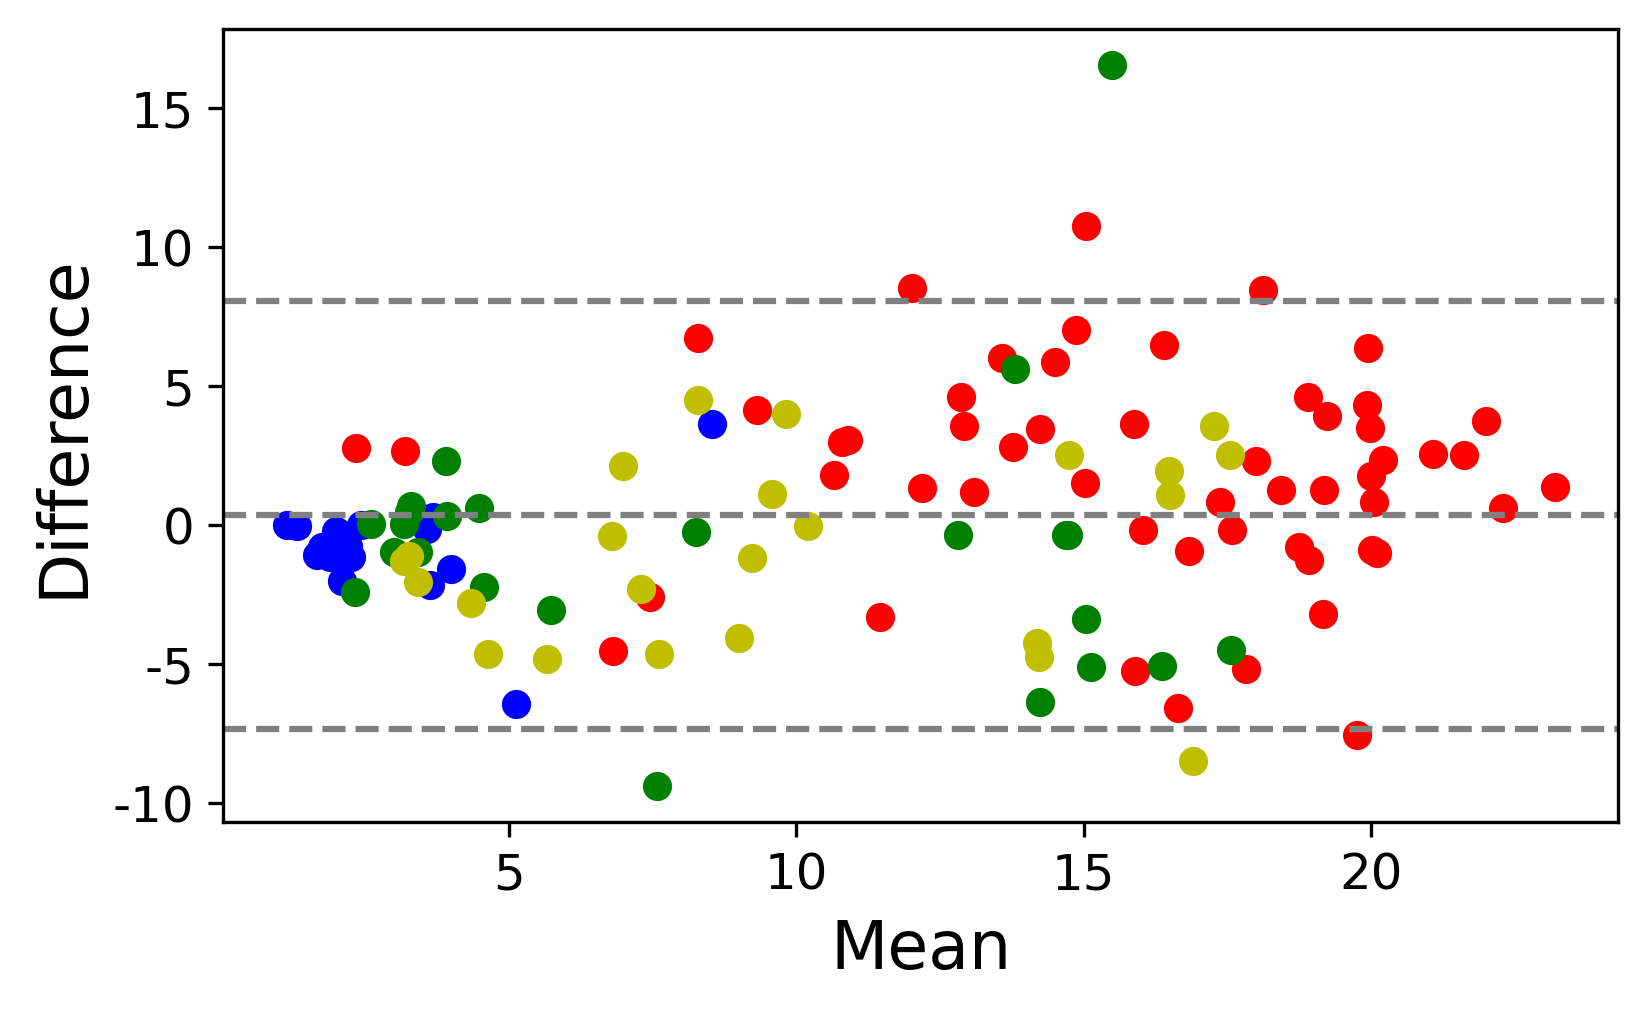

<Figure size 432x288 with 0 Axes>

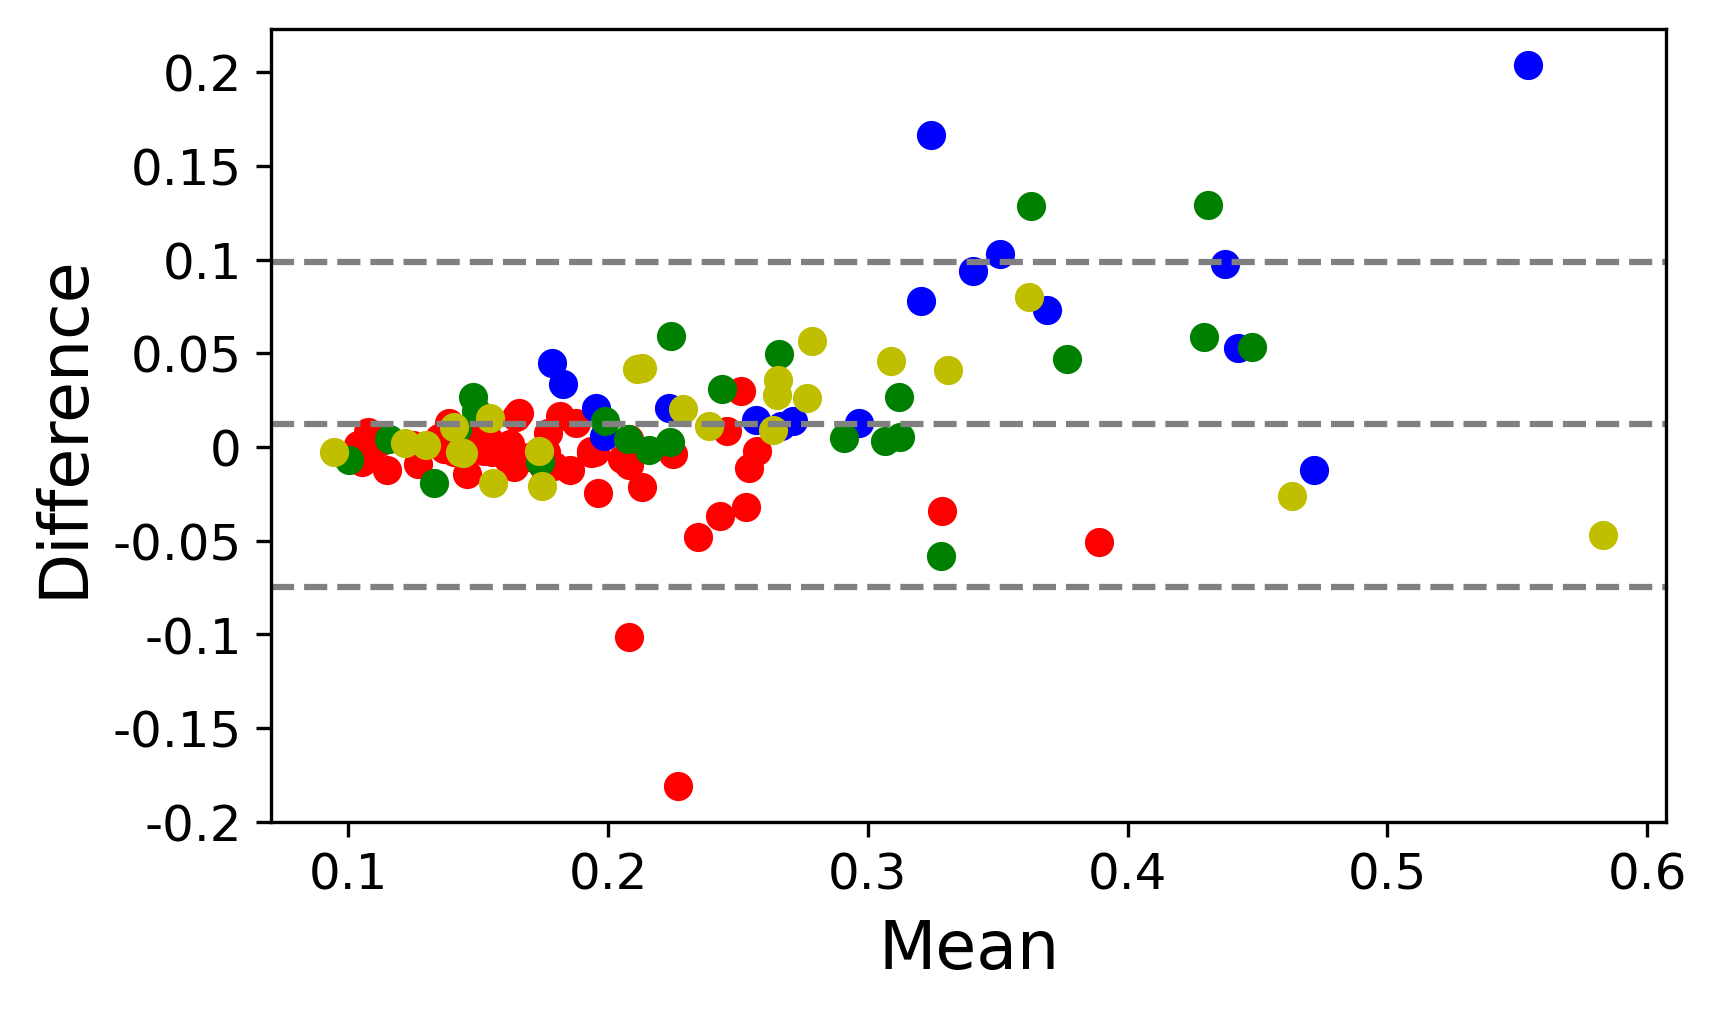

<Figure size 432x288 with 0 Axes>

In [85]:

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

"Box graph"
fig = plt.figure(figsize=(15,3),dpi=200,facecolor='w',edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(data=(Y_pred_pan[:,0],Y_pred_tum[:,0],Y_pred_nontum[:,0],Y_pred_pancreatitis[:,0]),linewidth=1,width=0.15)
plt.locator_params(nbins=5)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.grid(False)
plt.xticks([0,1,2,3],['Control','Tumor','Non-tumor','Pancreatitis'],fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.ylim([0,8])

# plt.title('Ktrans Comparison')
plt.savefig(os.path.join(_dir,"Pred_Ktrans_TK_tum_pan_thres.png"))

plt.subplot(1,3,2)
sns.boxplot(data=(Y_pred_pan[:,1],Y_pred_tum[:,1],Y_pred_nontum[:,1],Y_pred_pancreatitis[:,1]),linewidth=1,width=0.15)
plt.locator_params(nbins=5)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.grid(False)
plt.xticks([0,1,2,3],['Control','Tumor','Non-tumor','Pancreatitis'],fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.ylim([0,30])

# plt.title('kep Comparison')
plt.savefig(os.path.join(_dir,"Pred_kep_TK_tum_pan_thres.png"))
            
plt.subplot(1,3,3)
plt.locator_params(nbins=5)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.grid(False)
sns.boxplot(data=(Y_pred_pan[:,2],Y_pred_tum[:,2],Y_pred_nontum[:,2],Y_pred_pancreatitis[:,2]),linewidth=1,width=0.15)
plt.xticks([0,1,2,3],['Control','Tumor','Non-tumor','Pancreatitis'],fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))


plt.ylim([0,0.7])
# plt.title('Ve Comparison')
# plt.ylabel('Ve (1/min)')
plt.savefig(os.path.join(_dir,"Pred_Ve_TK_tum_pan_thres.png"))

"Box graph"
fig = plt.figure(figsize=(15,3),dpi=200,facecolor='w',edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(data=(Y_test_pan[:,0],Y_test_tum[:,0],Y_test_nontum[:,0],Y_test_pancreatitis[:,0]),linewidth=1,width=0.15)

plt.ylim([0,8])
plt.locator_params(nbins=5)
ax = plt.gca()
plt.grid(False)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks([0,1,2,3],['Control','Tumor','Non-tumor','Pancreatitis'],fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

plt.savefig(os.path.join(_dir,"Test_Ktrans_tum_pan_thres_label.png"))

plt.subplot(1,3,2)
sns.boxplot(data=(Y_test_pan[:,1],Y_test_tum[:,1],Y_test_nontum[:,1],Y_test_pancreatitis[:,1]),linewidth=1,width=0.15)

plt.ylim([0,30])
plt.locator_params(nbins=5)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.grid(False)
plt.xticks([0,1,2,3],['Control','Tumor','Non-tumor','Pancreatitis'],fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.savefig(os.path.join(_dir,"Test_kep_tum_pan_thres_label.png"))

plt.subplot(1,3,3)
sns.boxplot(data=(Y_test_pan[:,2],Y_test_tum[:,2],Y_test_nontum[:,2],Y_test_nontum[:,2]),linewidth=1,width=0.15)
plt.locator_params(nbins=5)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.grid(False)
plt.xticks([0,1,2,3],['Control','Tumor','Non-tumor','Pancreatitis'],fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.ylim([0,0.7])

plt.savefig(os.path.join(_dir,"Test_Ve_tum_pan_thres_label.png"))


"""
"""
"""
Comparison and analysis
"""

"""
Pred ROI analysis 
"""
"mean, std"
print('Ktrans analysis: mean, std')
print('Ctl: M%.2f S%.2f'%(np.mean(Y_pred_pan[:,0]),np.std(Y_pred_pan[:,0])))
print('Tum: M%.2f S%.2f'%(np.mean(Y_pred_tum[:,0]),np.std(Y_pred_tum[:,0])))
print('Non-tum: M%.2f S%.2f'%(np.mean(Y_pred_nontum[:,0]),np.std(Y_pred_nontum[:,0])))
print('Pancreatitis: M%.2f S%.2f'%(np.mean(Y_pred_pancreatitis[:,0]),np.std(Y_pred_pancreatitis[:,0])))
print('Contrast: M%.2f S%.2f'%(np.mean(Y_pred_contrast[:,0]),np.std(Y_pred_contrast[:,0])))

print('kep analysis: mean, std')
print('Ctl: M%.2f S%.2f'%(np.mean(Y_pred_pan[:,1]),np.std(Y_pred_pan[:,1])))
print('Tum: M%.2f S%.2f'%(np.mean(Y_pred_tum[:,1]),np.std(Y_pred_tum[:,1])))
print('Non-tum: M%.2f S%.2f'%(np.mean(Y_pred_nontum[:,1]),np.std(Y_pred_nontum[:,1])))
print('Pancreatitis: M%.2f S%.2f'%(np.mean(Y_pred_pancreatitis[:,1]),np.std(Y_pred_pancreatitis[:,1])))
print('Contrast: M%.2f S%.2f'%(np.mean(Y_pred_contrast[:,1]),np.std(Y_pred_contrast[:,1])))

print('Ve analysis: mean, std')
print('Ctl: M%.2f S%.2f'%(np.mean(Y_pred_pan[:,2]),np.std(Y_pred_pan[:,2])))
print('Tum: M%.2f S%.2f'%(np.mean(Y_pred_tum[:,2]),np.std(Y_pred_tum[:,2])))
print('Non-tum: M%.2f S%.2f'%(np.mean(Y_pred_nontum[:,2]),np.std(Y_pred_nontum[:,2])))
print('Pancreatitis: M%.2f S%.2f'%(np.mean(Y_pred_pancreatitis[:,2]),np.std(Y_pred_pancreatitis[:,2])))
print('Contrast: M%.2f S%.2f'%(np.mean(Y_pred_contrast[:,2]),np.std(Y_pred_contrast[:,2])))

"T-test"
import scipy 
"T-test"
print('Ktrans analysis: T-test')
print(scipy.stats.ttest_ind(Y_pred_pan[:,0],Y_pred_tum[:,0]))
print(scipy.stats.ttest_ind(Y_pred_pan[:,0],Y_pred_nontum[:,0]))
print(scipy.stats.ttest_ind(Y_pred_pan[:,0],Y_pred_pancreatitis[:,0]))
print(scipy.stats.ttest_ind(Y_pred_tum[:,0],Y_pred_nontum[:,0]))
print('kep analysis: T-test')
print(scipy.stats.ttest_ind(Y_pred_pan[:,1],Y_pred_tum[:,1]))
print(scipy.stats.ttest_ind(Y_pred_pan[:,1],Y_pred_nontum[:,1]))
print(scipy.stats.ttest_ind(Y_pred_pan[:,1],Y_pred_pancreatitis[:,1]))
print(scipy.stats.ttest_ind(Y_pred_tum[:,1],Y_pred_nontum[:,1]))

print('Ve analysis: T-test')
print(scipy.stats.ttest_ind(Y_pred_pan[:,2],Y_pred_tum[:,2]))
print(scipy.stats.ttest_ind(Y_pred_pan[:,2],Y_pred_nontum[:,2]))
print(scipy.stats.ttest_ind(Y_pred_pan[:,2],Y_pred_pancreatitis[:,2]))
print(scipy.stats.ttest_ind(Y_pred_tum[:,2],Y_pred_nontum[:,2]))

"""
Test ROI analysis 
"""
"mean, std"
print('Ktrans analysis: mean, std')
print('Ctl: M%.2f S%.2f'%(np.mean(Y_test_pan[:,0]),np.std(Y_test_pan[:,0])))
print('Tum: M%.2f S%.2f'%(np.mean(Y_test_tum[:,0]),np.std(Y_test_tum[:,0])))
print('Non-tum: M%.2f S%.2f'%(np.mean(Y_test_nontum[:,0]),np.std(Y_test_nontum[:,0])))
print('Pancreatitis: M%.2f S%.2f'%(np.mean(Y_test_pancreatitis[:,0]),np.std(Y_test_pancreatitis[:,0])))
print('Contrast: M%.2f S%.2f'%(np.mean(Y_test_contrast[:,0]),np.std(Y_test_contrast[:,0])))


print('kep analysis: mean, std')
print('Ctl: M%.2f S%.2f'%(np.mean(Y_test_pan[:,1]),np.std(Y_test_pan[:,1])))
print('Tum: M%.2f S%.2f'%(np.mean(Y_test_tum[:,1]),np.std(Y_test_tum[:,1])))
print('Non-tum: M%.2f S%.2f'%(np.mean(Y_test_nontum[:,1]),np.std(Y_test_nontum[:,1])))
print('Pancreatitis: M%.2f S%.2f'%(np.mean(Y_test_pancreatitis[:,1]),np.std(Y_test_pancreatitis[:,1])))
print('Contrast: M%.2f S%.2f'%(np.mean(Y_test_contrast[:,1]),np.std(Y_test_contrast[:,1])))

print('Ve analysis: mean, std')
print('Ctl: M%.2f S%.2f'%(np.mean(Y_test_pan[:,2]),np.std(Y_test_pan[:,2])))
print('Tum: M%.2f S%.2f'%(np.mean(Y_test_tum[:,2]),np.std(Y_test_tum[:,2])))
print('Non-tum: M%.2f S%.2f'%(np.mean(Y_test_nontum[:,2]),np.std(Y_test_nontum[:,2])))
print('Pancreatitis: M%.2f S%.2f'%(np.mean(Y_test_pancreatitis[:,2]),np.std(Y_test_pancreatitis[:,2])))
print('Contrast: M%.2f S%.2f'%(np.mean(Y_test_contrast[:,2]),np.std(Y_test_contrast[:,2])))

"T-test"
import scipy 
"T-test"
print('Ktrans analysis: T-test')
print(scipy.stats.ttest_ind(Y_test_pan[:,0],Y_test_tum[:,0]))
print(scipy.stats.ttest_ind(Y_test_pan[:,0],Y_test_nontum[:,0]))
print(scipy.stats.ttest_ind(Y_test_pan[:,0],Y_test_pancreatitis[:,0]))
print(scipy.stats.ttest_ind(Y_test_tum[:,0],Y_test_nontum[:,0]))

print('kep analysis: T-test')
print(scipy.stats.ttest_ind(Y_test_pan[:,1],Y_test_tum[:,1]))
print(scipy.stats.ttest_ind(Y_test_pan[:,1],Y_test_nontum[:,1]))
print(scipy.stats.ttest_ind(Y_test_pan[:,1],Y_test_pancreatitis[:,1]))
print(scipy.stats.ttest_ind(Y_test_tum[:,1],Y_test_nontum[:,1]))

print('Ve analysis: T-test')
print(scipy.stats.ttest_ind(Y_test_pan[:,2],Y_test_tum[:,2]))
print(scipy.stats.ttest_ind(Y_test_pan[:,2],Y_test_nontum[:,2]))
print(scipy.stats.ttest_ind(Y_test_pan[:,2],Y_test_pancreatitis[:,2]))
print(scipy.stats.ttest_ind(Y_test_tum[:,2],Y_test_nontum[:,2]))

"""
"""
Y_pred_all = np.concatenate((Y_pred_pan,Y_pred_tum,Y_pred_nontum,Y_pred_pancreatitis),axis=0)
Y_test_all = np.concatenate((Y_test_pan,Y_test_tum,Y_test_nontum,Y_test_pancreatitis),axis=0)

plt.figure(facecolor='w',edgecolor='k',dpi=300,figsize=(6,3.5))

bland_altman_plot_4_categories((Y_test_pan[:,0],Y_test_tum[:,0],Y_test_nontum[:,0],Y_test_pancreatitis[:,0],Y_test_all[:,0]),
                               (Y_pred_pan[:,0],Y_pred_tum[:,0],Y_pred_nontum[:,0],Y_pred_pancreatitis[:,0],Y_pred_all[:,0]))
# plt.title(r'K\_trans (\frac{1}{min})',fontsize=20)
plt.show()
plt.savefig(os.path.join(_dir,'Bland-Altman Plot (Ktrans).png'))



plt.figure(facecolor='w',edgecolor='k',dpi=300,figsize=(6,3.5))

bland_altman_plot_4_categories((Y_test_pan[:,1],Y_test_tum[:,1],Y_test_nontum[:,1],Y_test_pancreatitis[:,1],Y_test_all[:,1]),
                               (Y_pred_pan[:,1],Y_pred_tum[:,1],Y_pred_nontum[:,1],Y_pred_pancreatitis[:,1],Y_pred_all[:,1]))
# plt.title('Bland-Altman Plot (kep)')
plt.show()
plt.savefig(os.path.join(_dir,'Bland-Altman Plot (kep)'))

plt.figure(facecolor='w',edgecolor='k',dpi=300,figsize=(6,3.5))

bland_altman_plot_4_categories((Y_test_pan[:,2],Y_test_tum[:,2],Y_test_nontum[:,2],Y_test_pancreatitis[:,2],Y_test_all[:,2]),
                               (Y_pred_pan[:,2],Y_pred_tum[:,2],Y_pred_nontum[:,2],Y_pred_pancreatitis[:,2],Y_pred_all[:,2]))

# plt.title('Bland-Altman Plot (Ve)')
plt.show()
plt.savefig(os.path.join(_dir,'Bland-Altman Plot (Ve)'))


(120, 2)
(120, 2)
(120, 2)


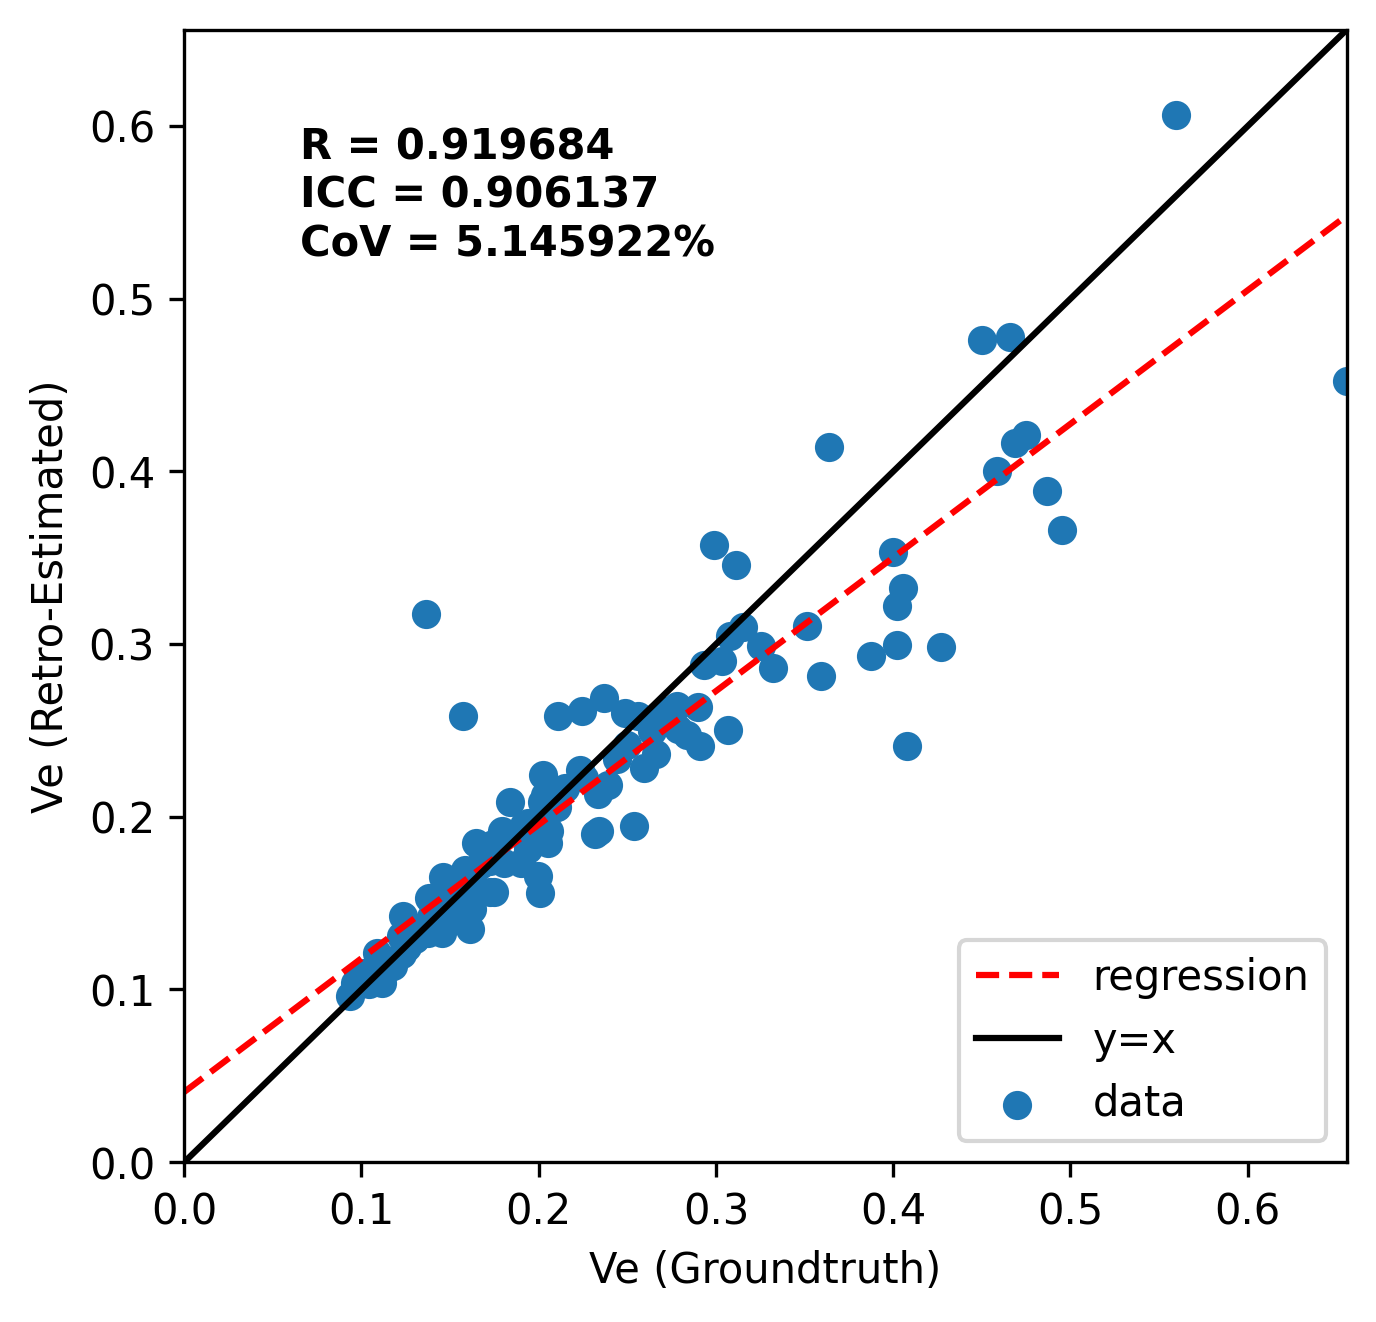

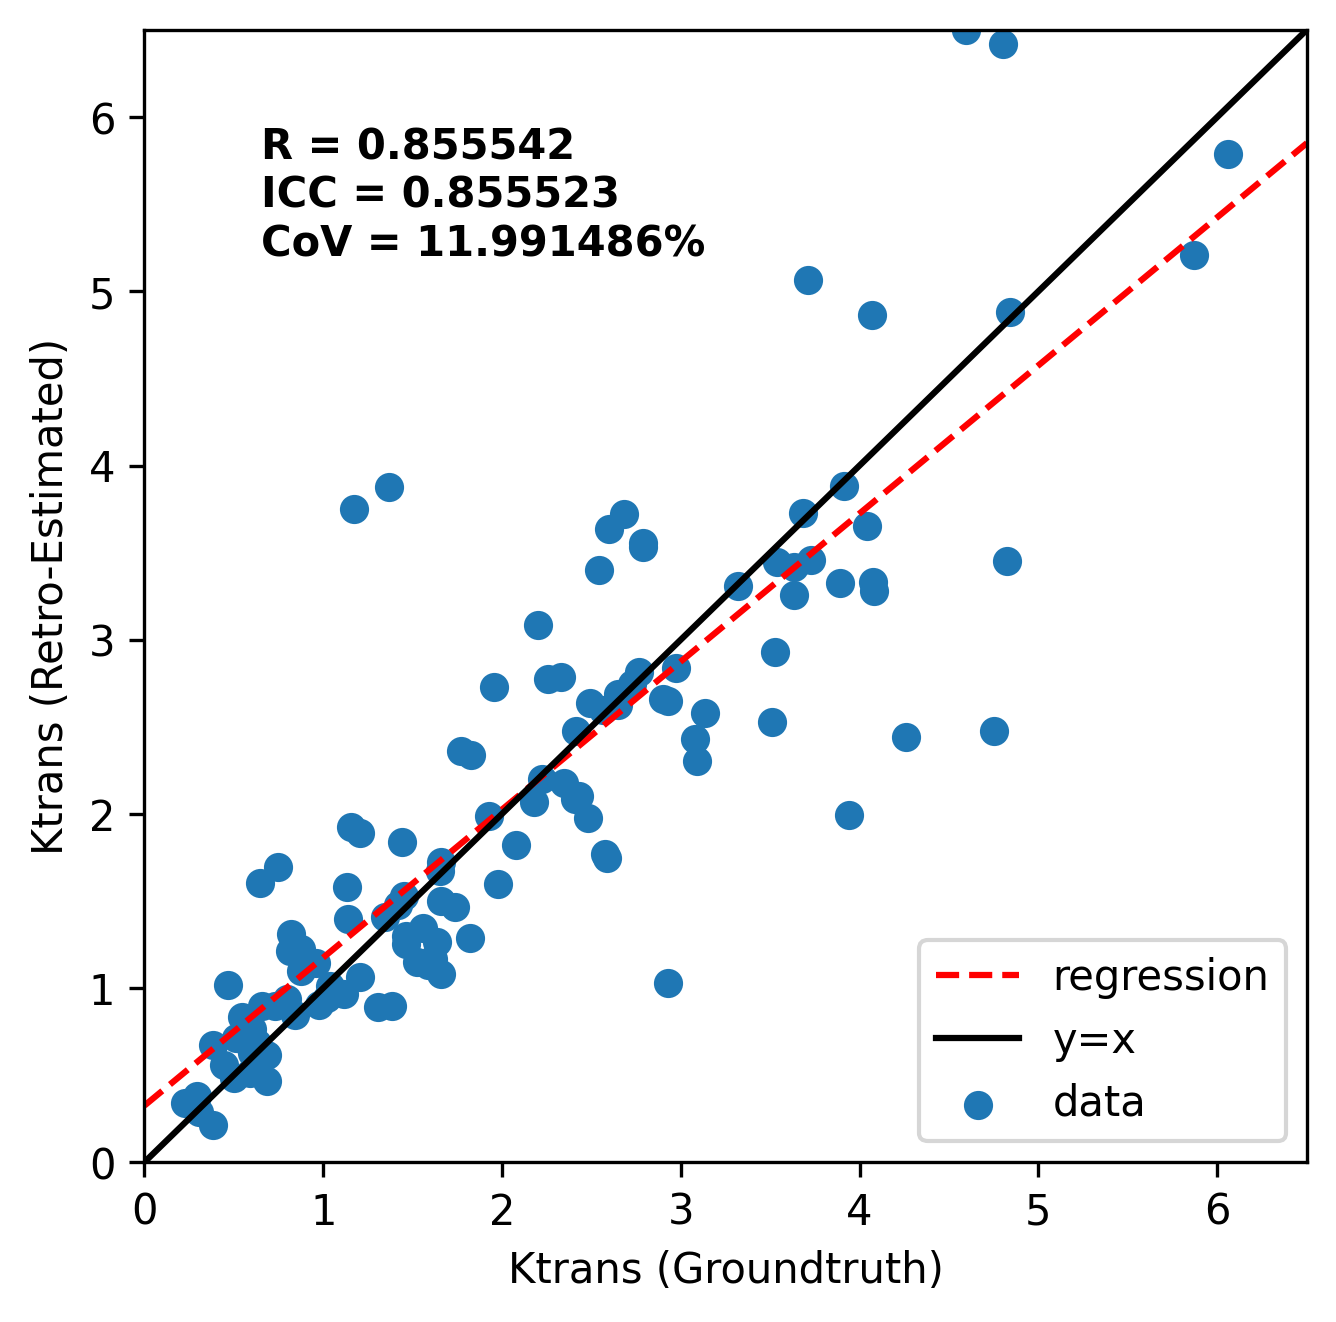

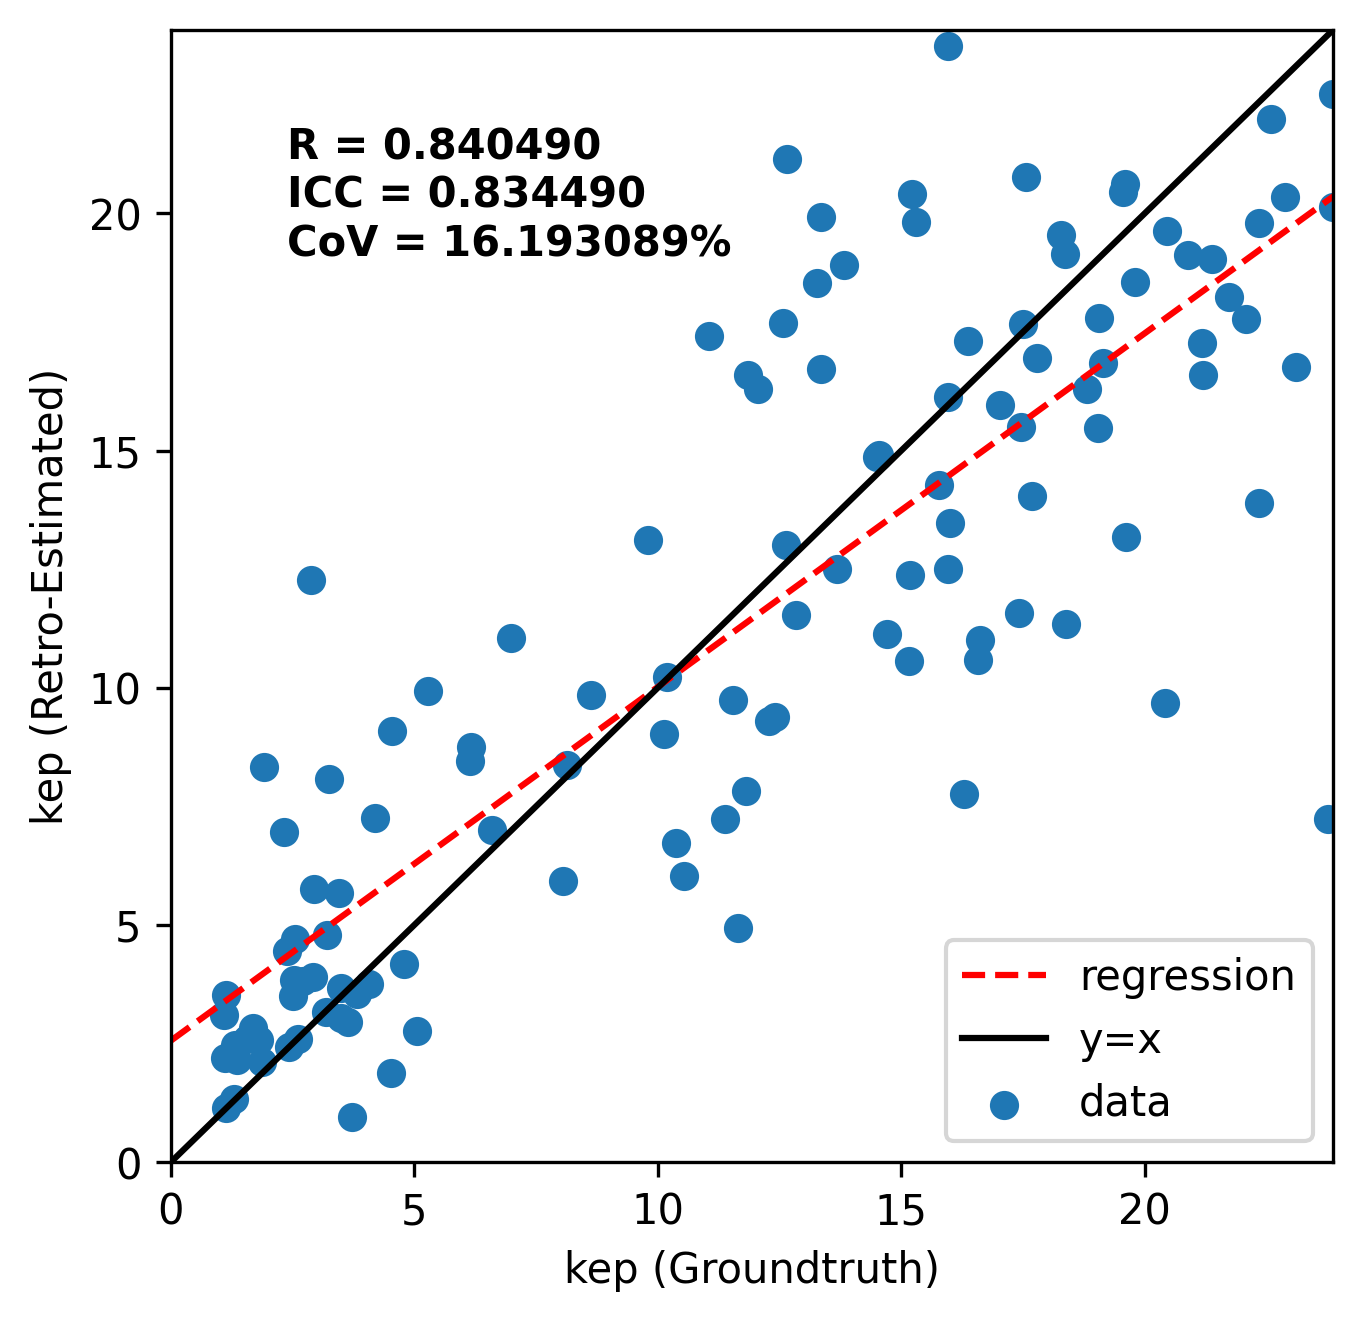

In [86]:
mode='do'

MyPlot(Y_test_all[:,2],Y_pred_all[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([Y_pred_all[:,2],Y_test_all[:,2]]),_dir,'Vp_pd_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_all[:,0],Y_pred_all[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],np.max([Y_pred_all[:,0],Y_test_all[:,0]]),_dir,'Ktrans_pd_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_all[:,1],Y_pred_all[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],np.max([Y_pred_all[:,1],Y_test_all[:,1]]),_dir,'kep_pd_Tofts_refit_mPM',mode=mode)



(54, 2)
(54, 2)
(54, 2)


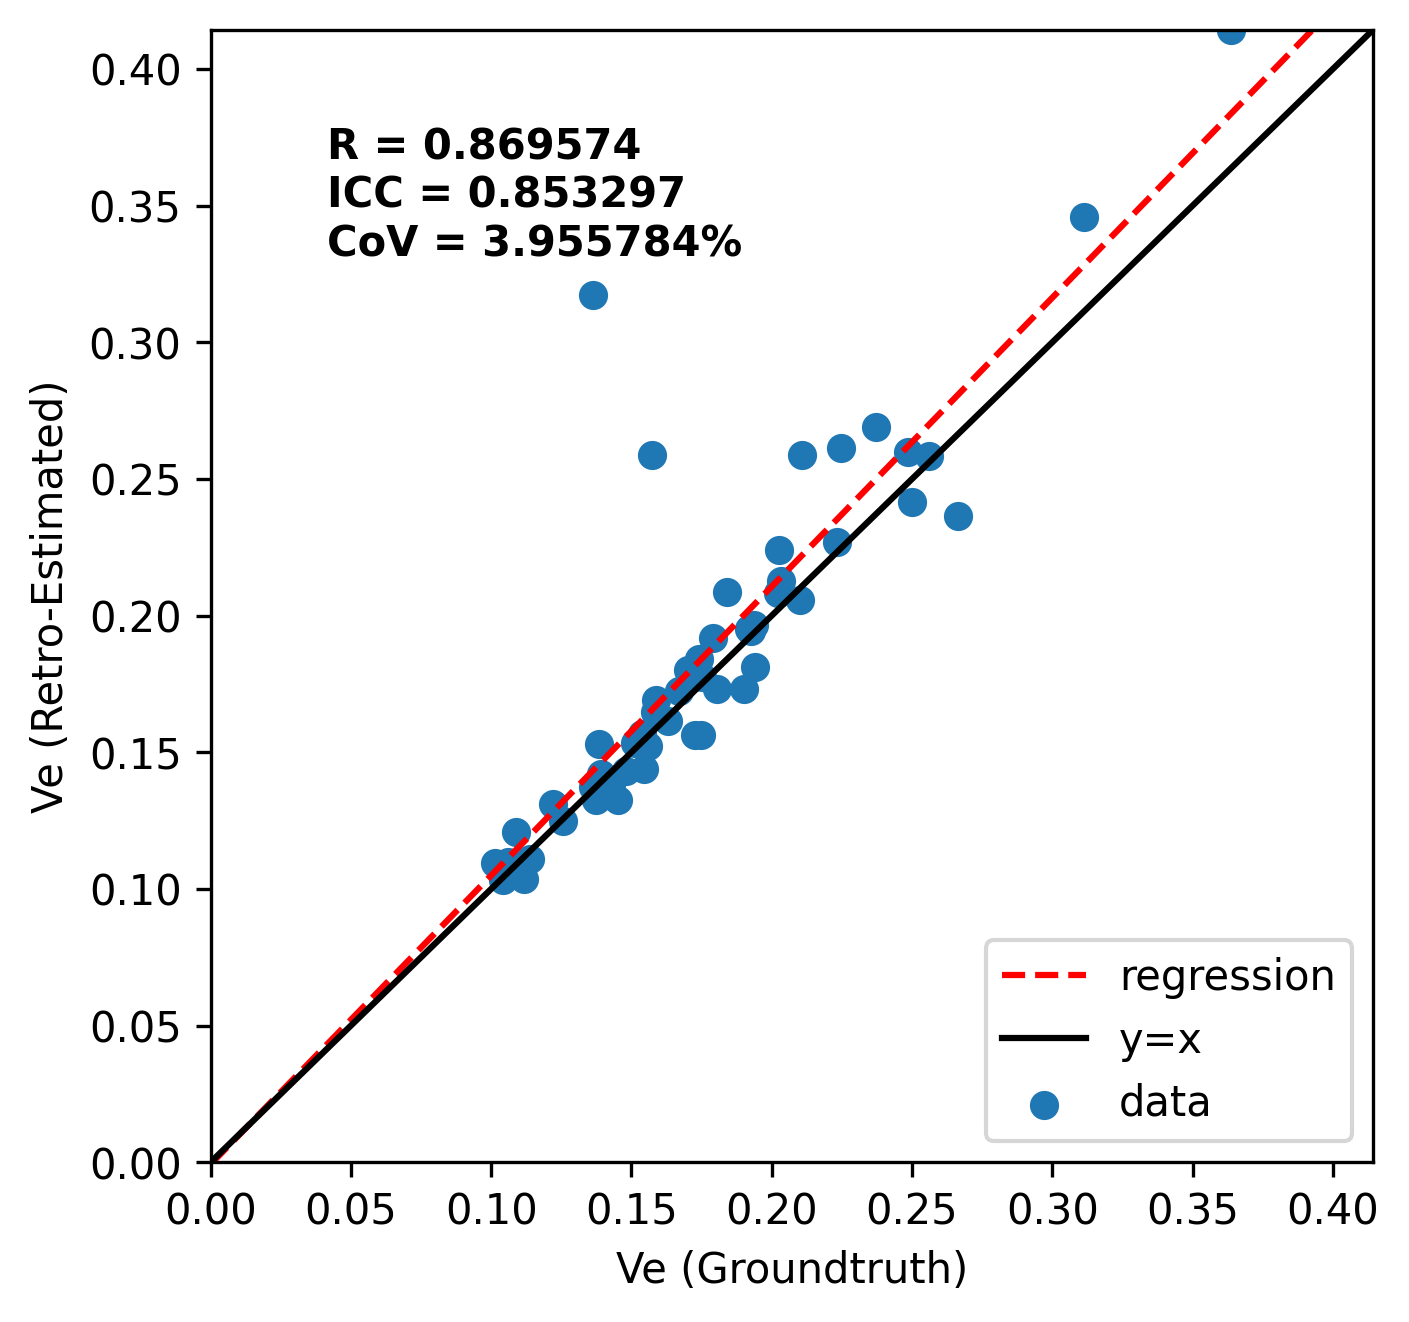

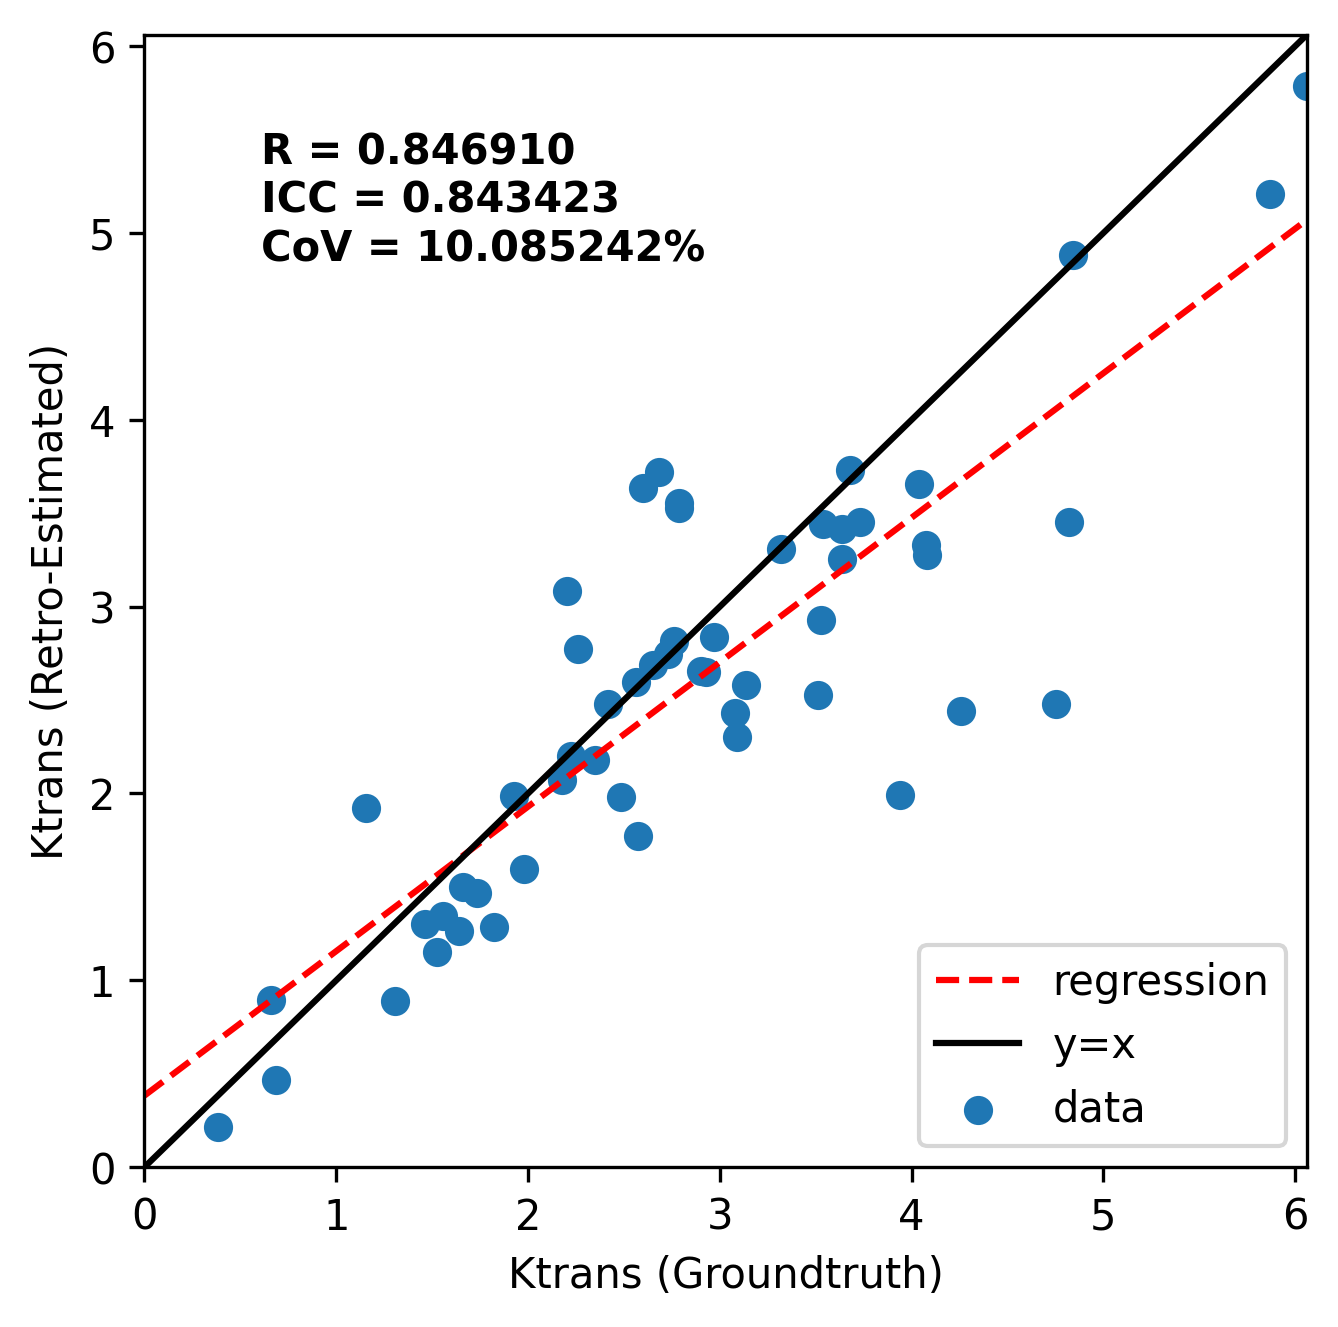

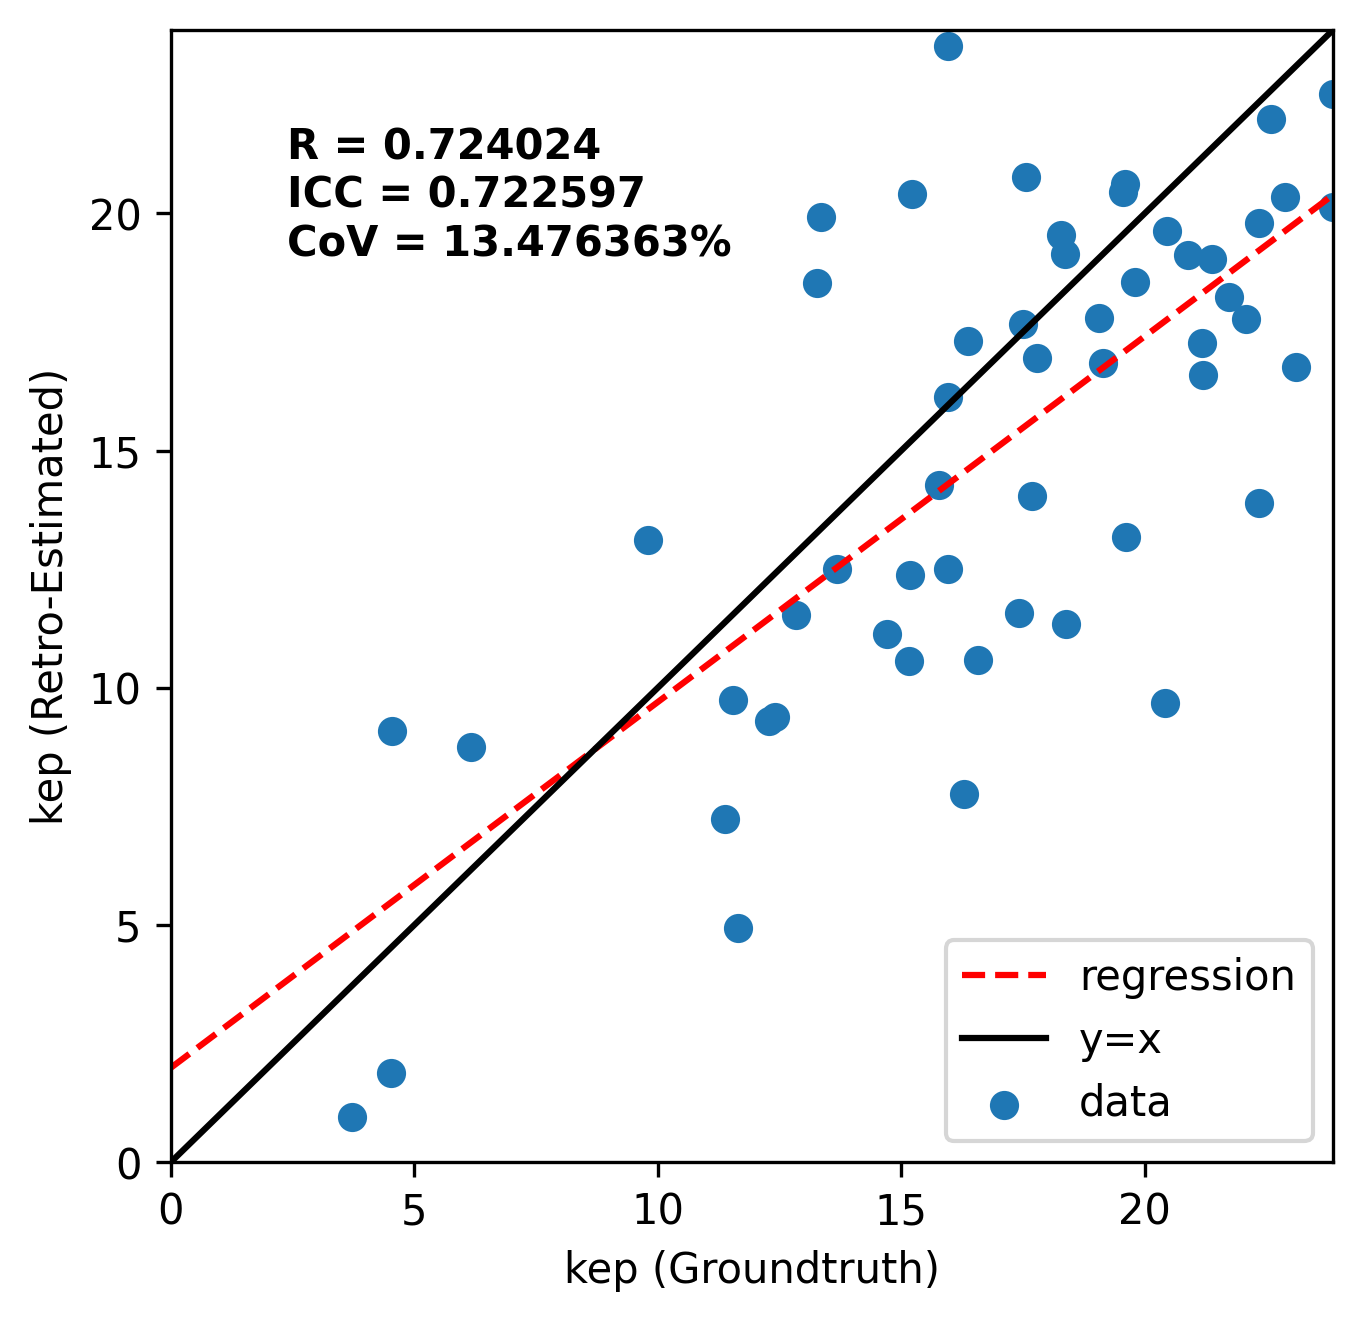

In [87]:
mode='do'

MyPlot(Y_test_pan[:,2],Y_pred_pan[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([Y_pred_pan[:,2],Y_test_pan[:,2]]),_dir,'Vp_pan_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_pan[:,0],Y_pred_pan[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],np.max([Y_pred_pan[:,0],Y_test_pan[:,0]]),_dir,'Ktrans_pan_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_pan[:,1],Y_pred_pan[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],np.max([Y_pred_pan[:,1],Y_test_pan[:,1]]),_dir,'kep_pan_Tofts_refit_mPM',mode=mode)



(18, 2)
(18, 2)
(18, 2)


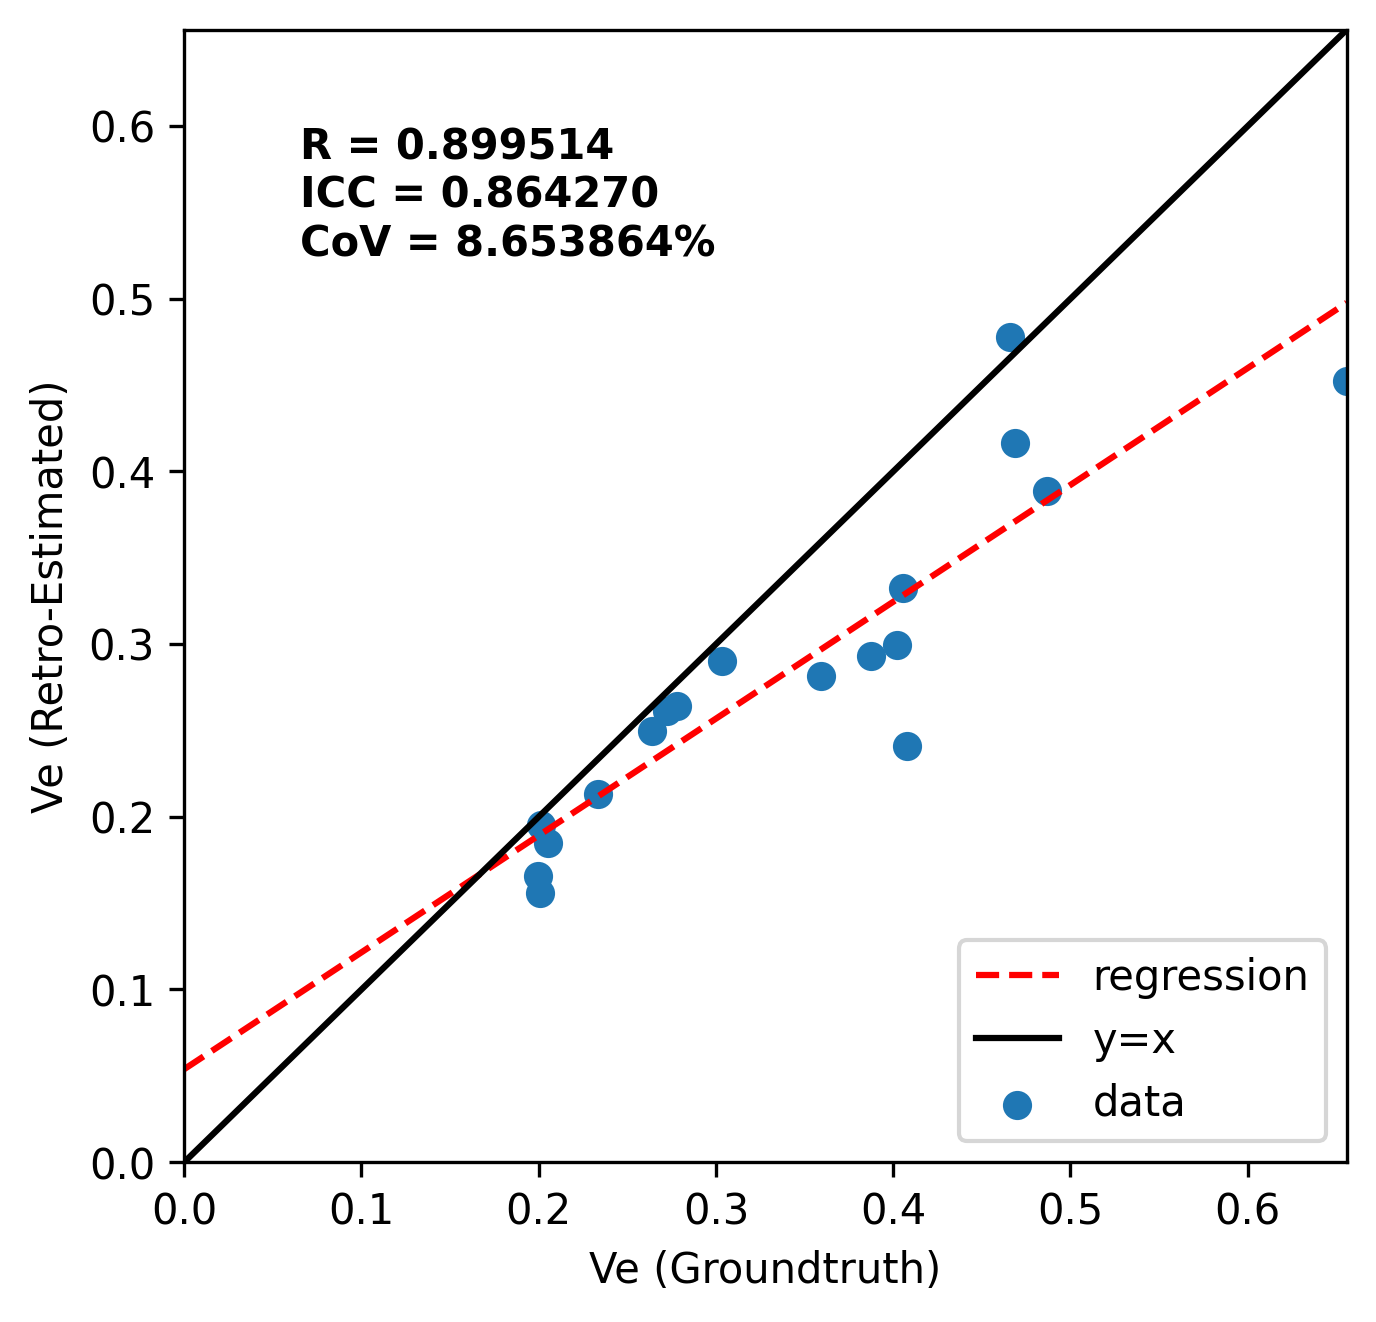

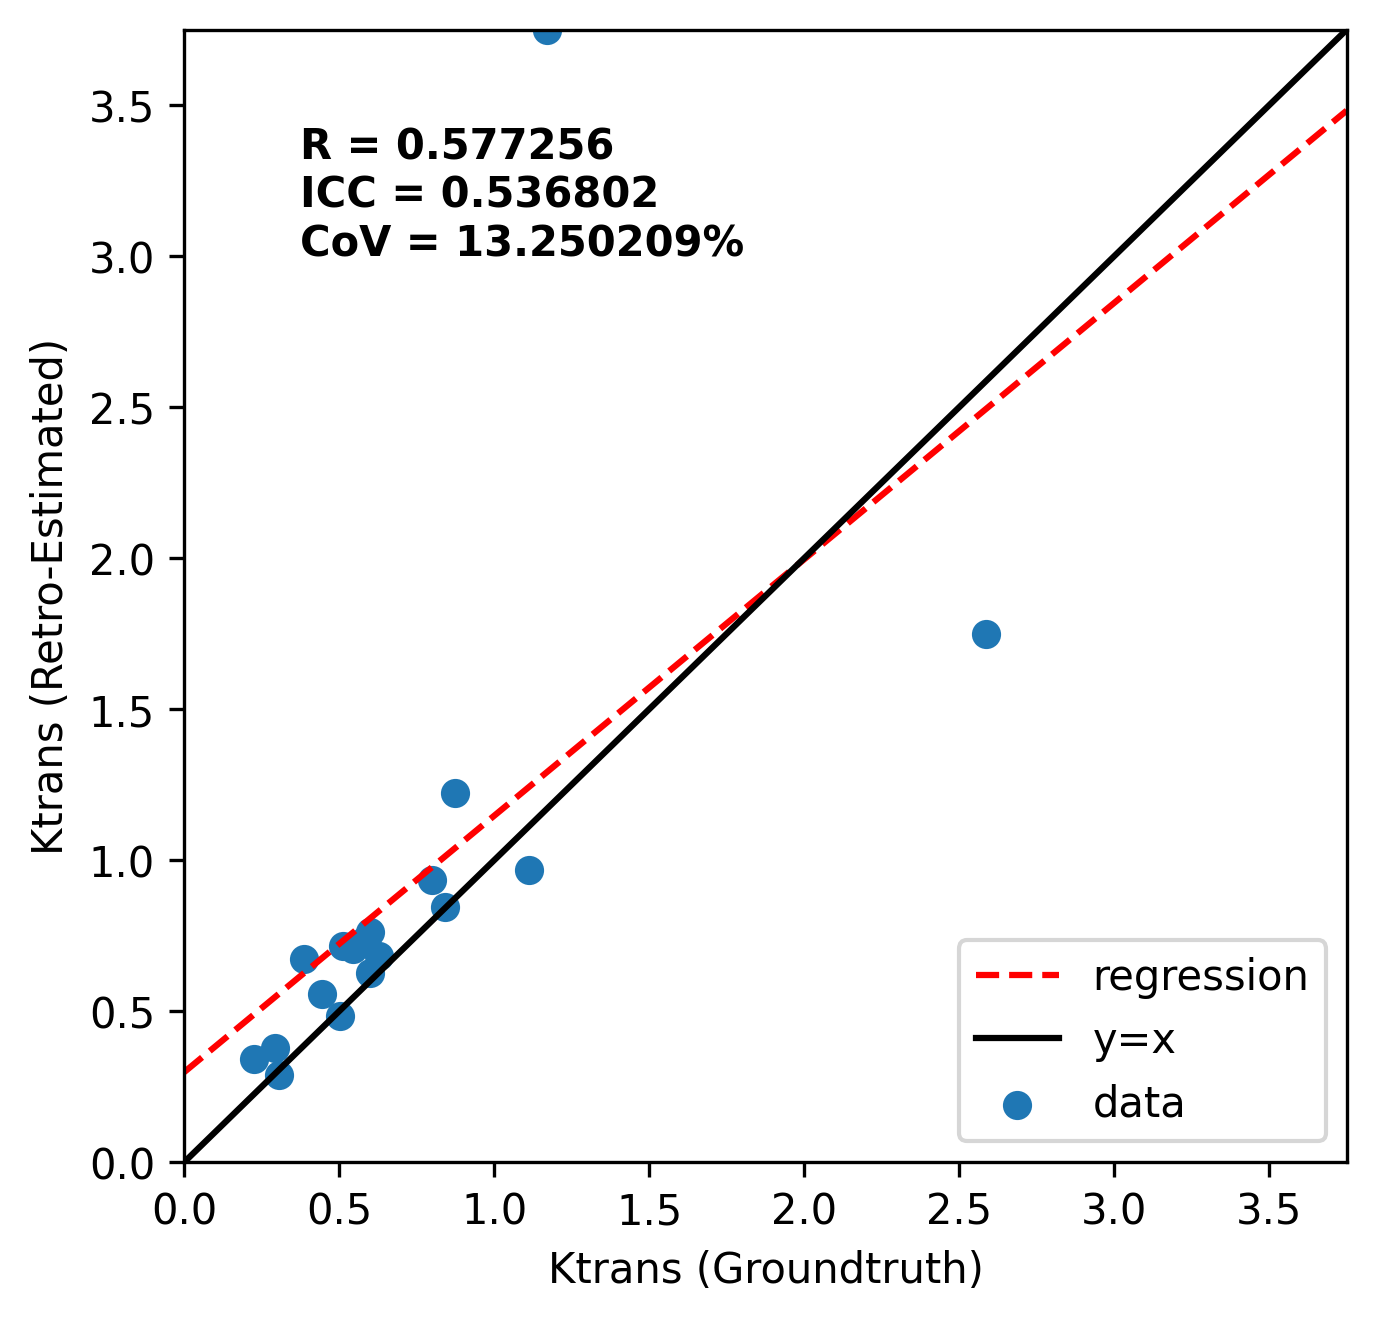

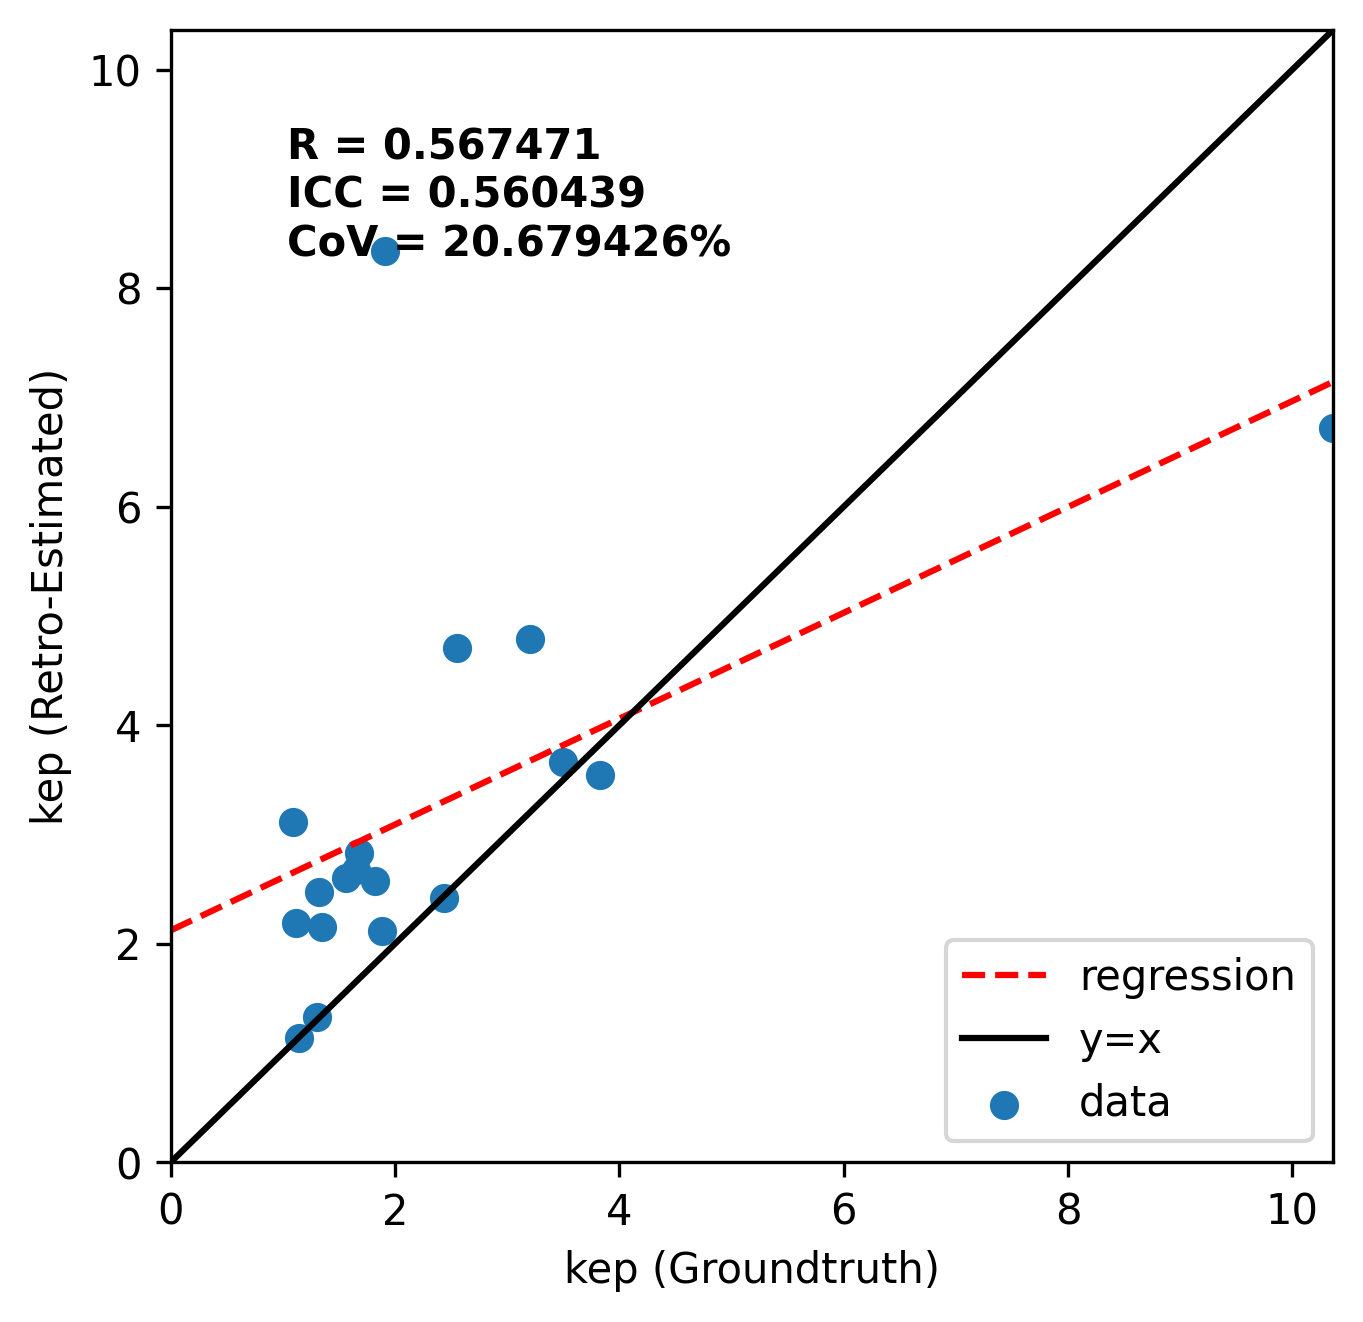

In [88]:
mode='do'
MyPlot(Y_test_tum[:,2],Y_pred_tum[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([Y_pred_tum[:,2],Y_test_tum[:,2]]),_dir,'Vp_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_tum[:,0],Y_pred_tum[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],np.max([Y_pred_tum[:,0],Y_test_tum[:,0]]),_dir,'Ktrans_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_tum[:,1],Y_pred_tum[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],np.max([Y_pred_tum[:,1],Y_test_tum[:,1]]),_dir,'kep_tum_Tofts_refit_mPM',mode=mode)



(24, 2)
(24, 2)
(24, 2)


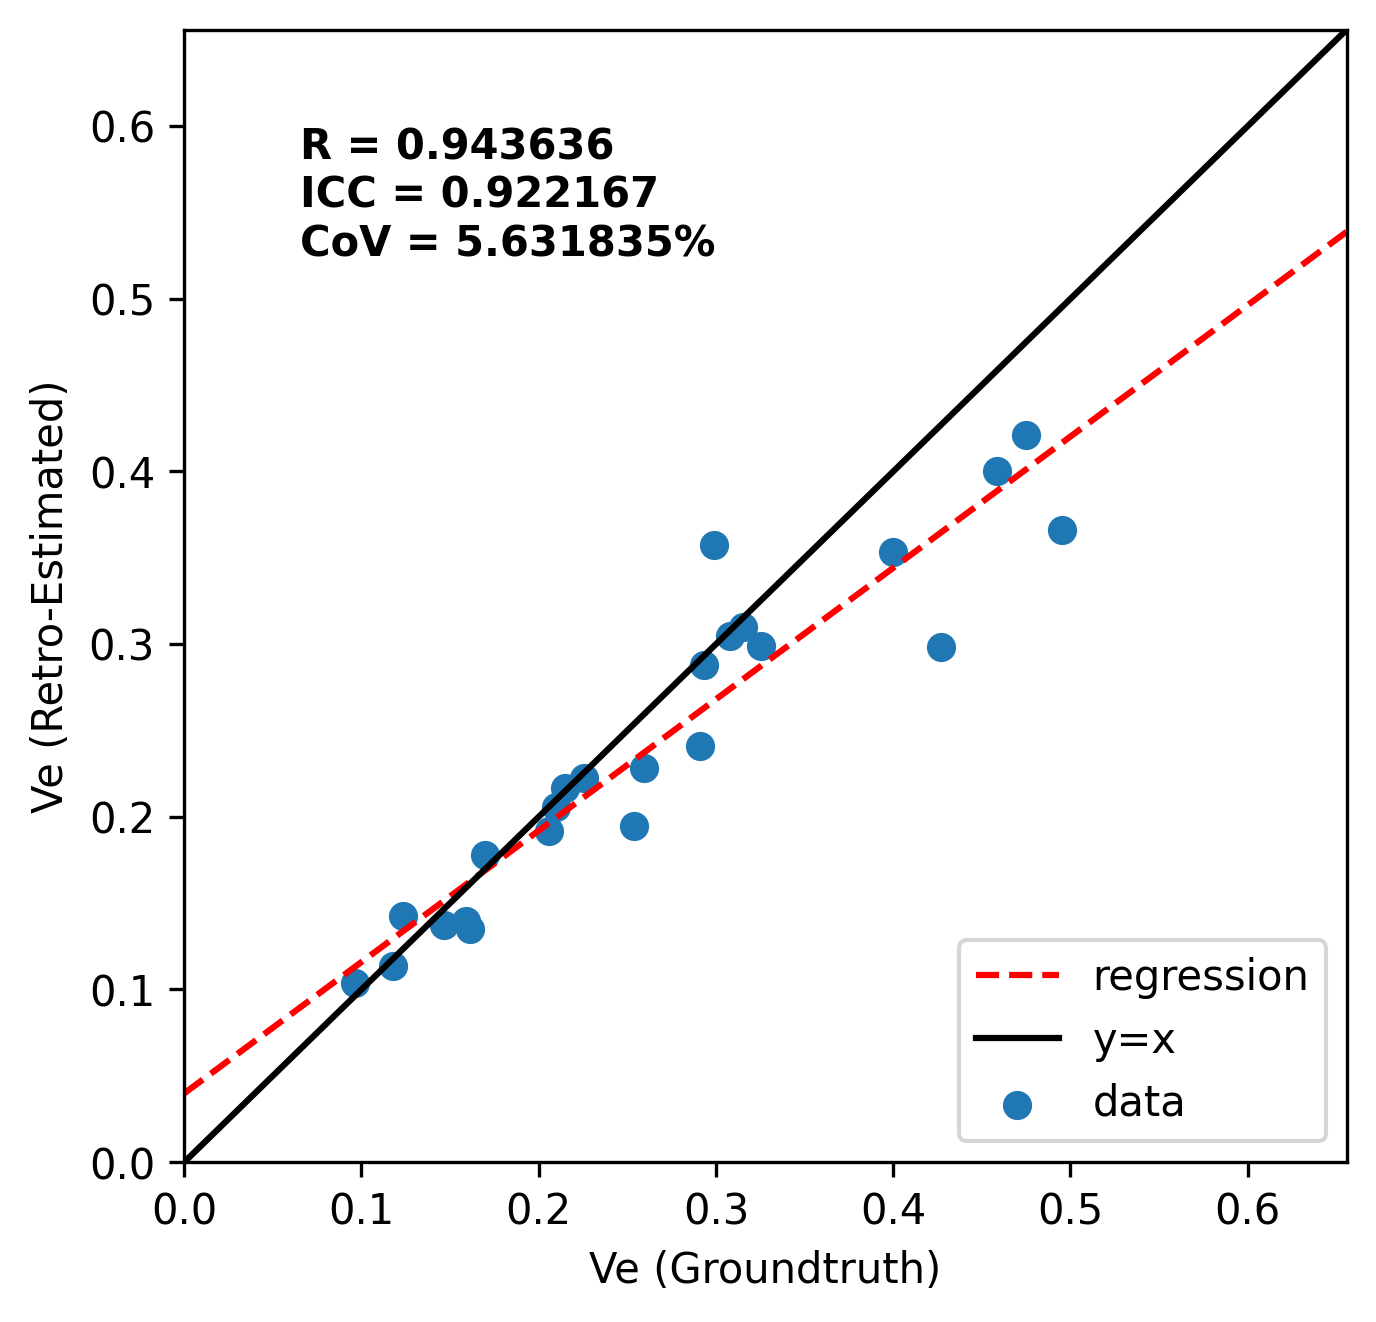

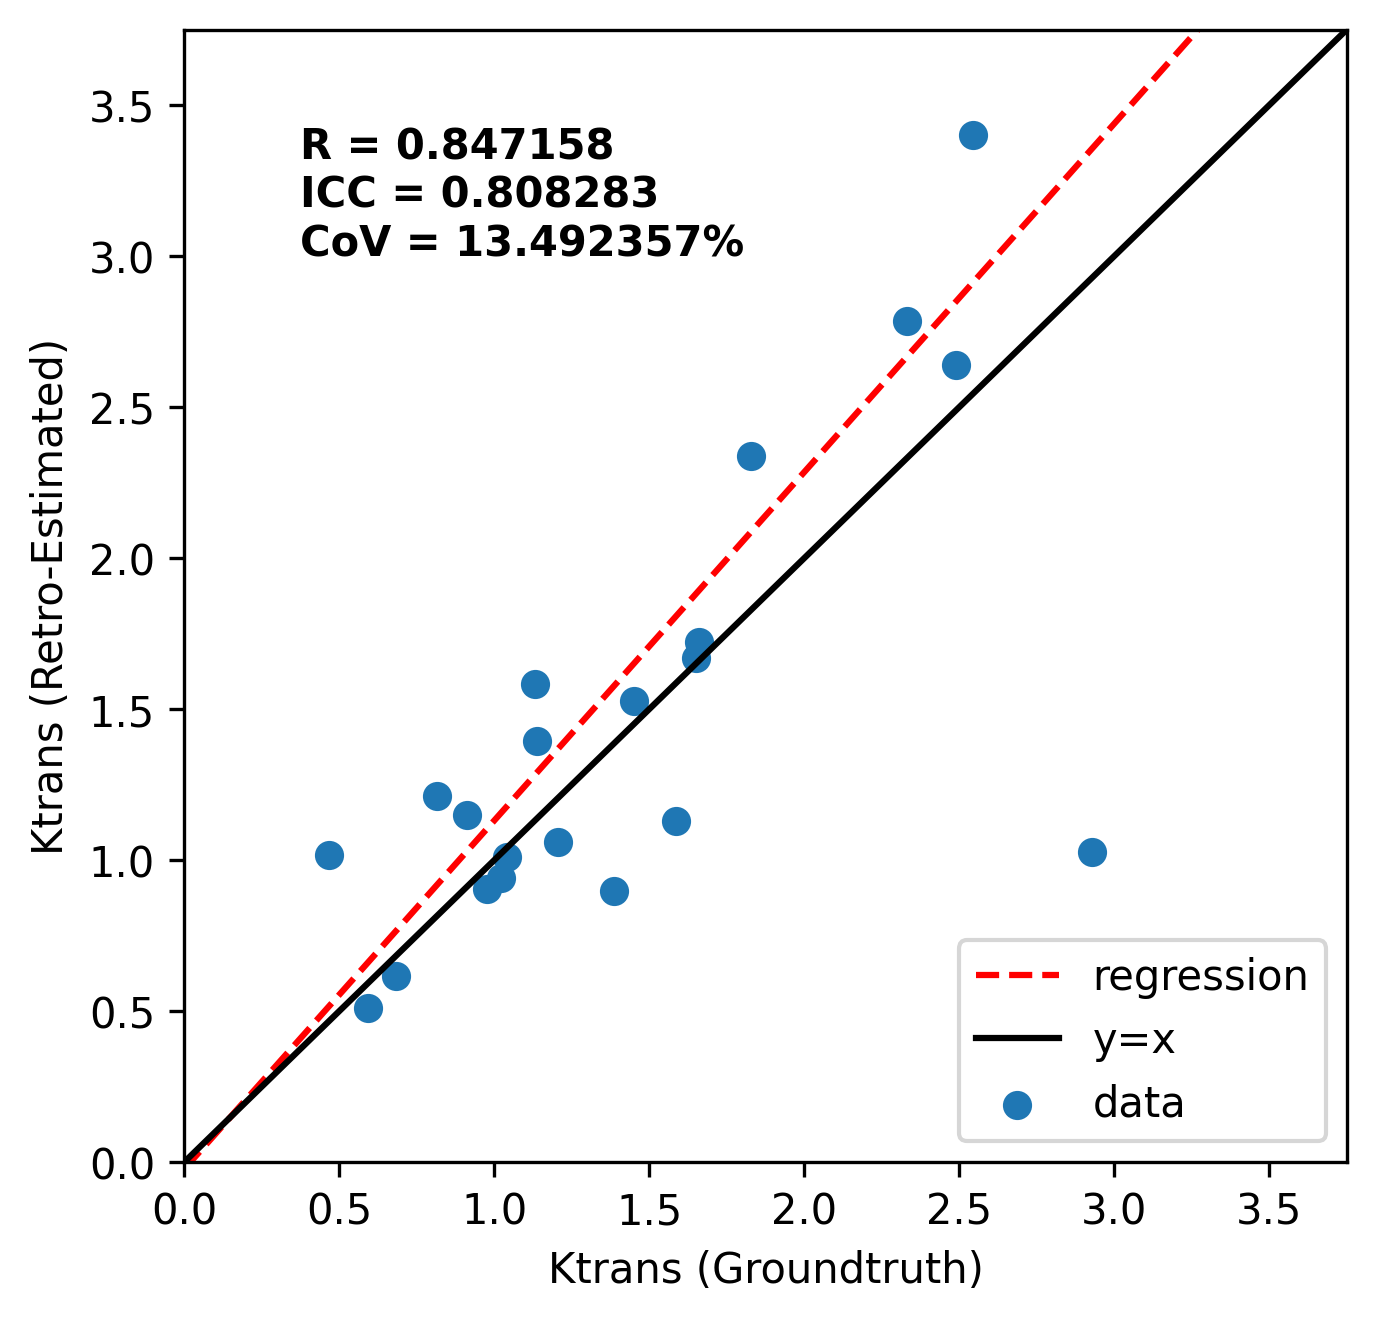

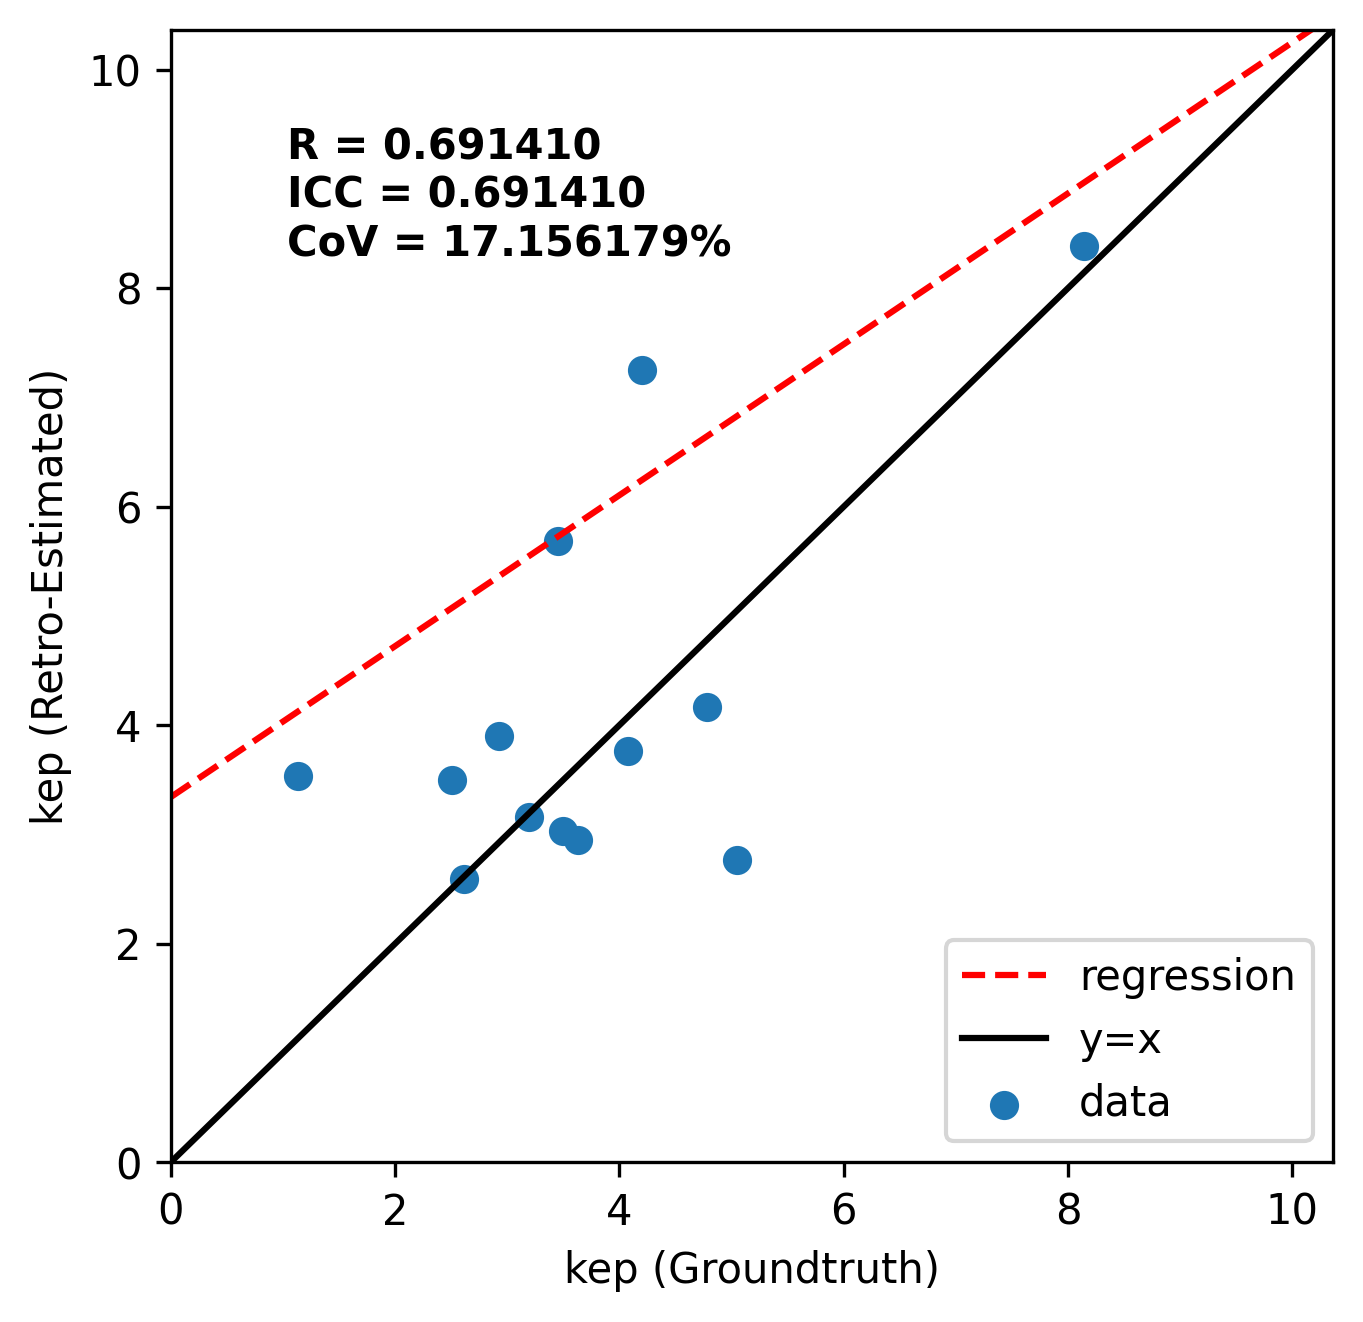

In [90]:
mode='do'
MyPlot(Y_test_nontum[:,2],Y_pred_nontum[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([Y_pred_tum[:,2],Y_test_tum[:,2]]),_dir,'Vp_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_nontum[:,0],Y_pred_nontum[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],np.max([Y_pred_tum[:,0],Y_test_tum[:,0]]),_dir,'Ktrans_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_nontum[:,1],Y_pred_nontum[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],np.max([Y_pred_tum[:,1],Y_test_tum[:,1]]),_dir,'kep_tum_Tofts_refit_mPM',mode=mode)



(24, 2)
(24, 2)
(24, 2)


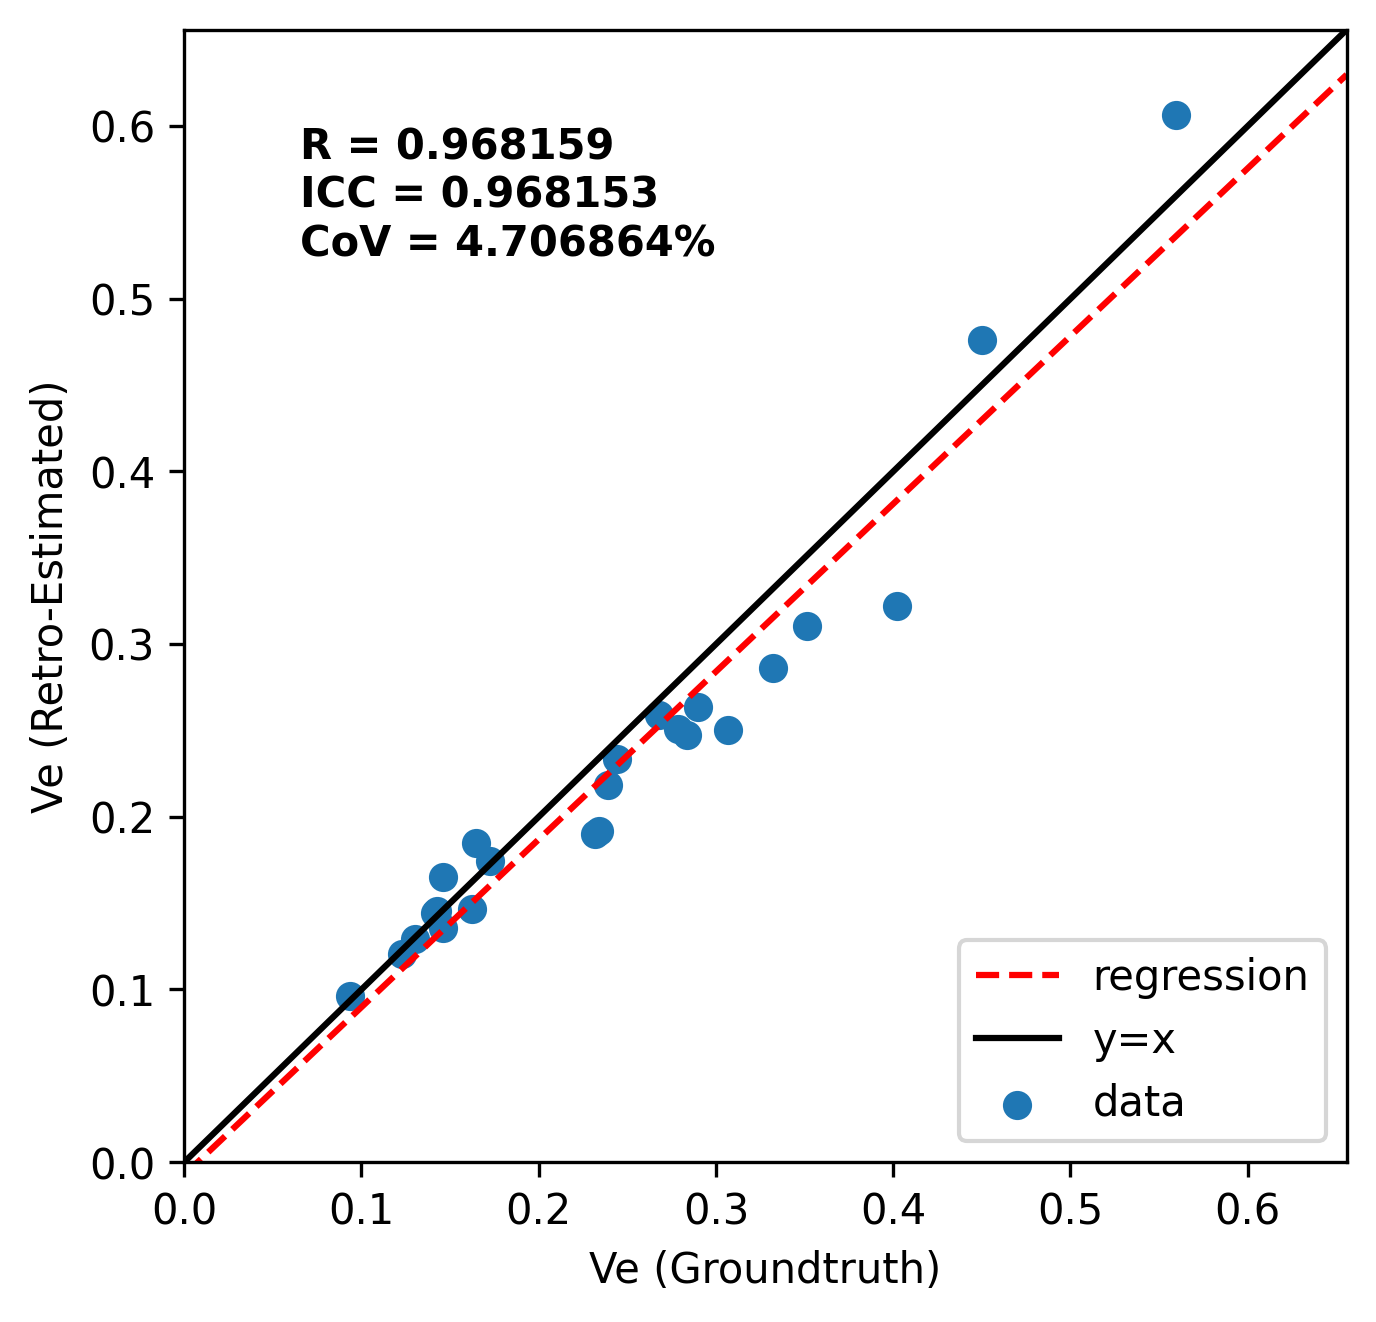

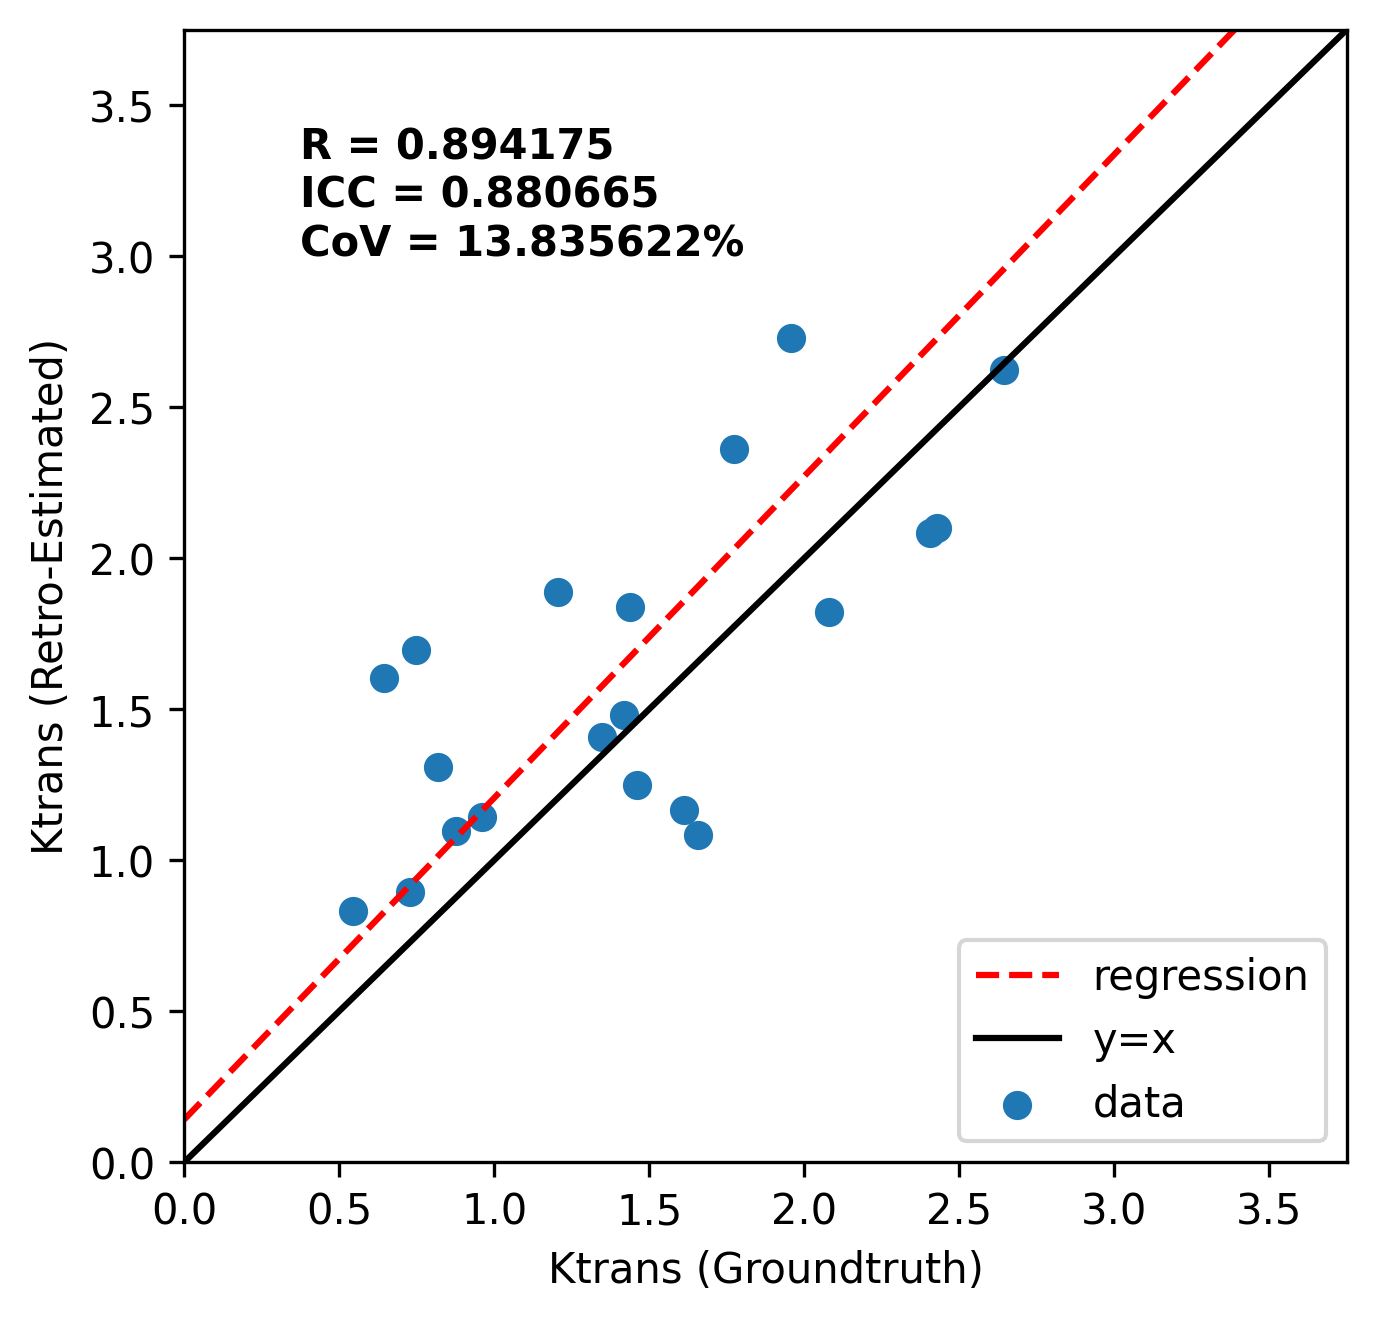

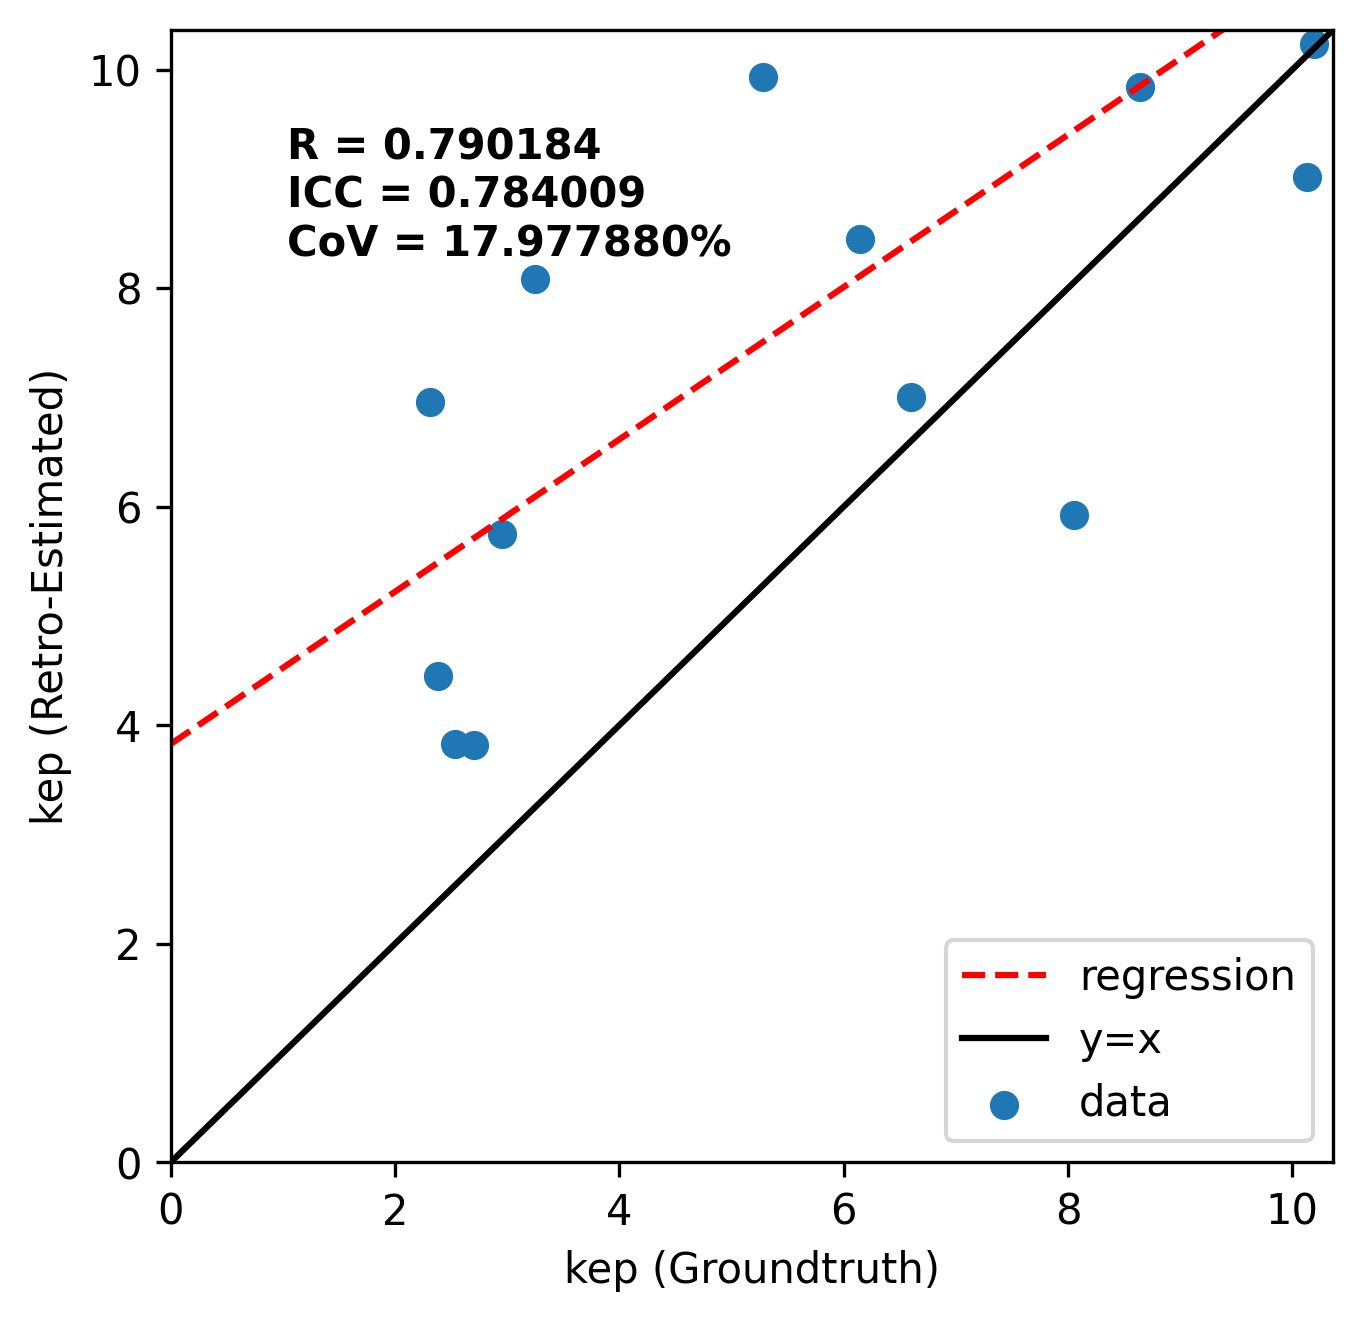

In [91]:
mode='do'
MyPlot(Y_test_pancreatitis[:,2],Y_pred_pancreatitis[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([Y_pred_tum[:,2],Y_test_tum[:,2]]),_dir,'Vp_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_pancreatitis[:,0],Y_pred_pancreatitis[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],np.max([Y_pred_tum[:,0],Y_test_tum[:,0]]),_dir,'Ktrans_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_pancreatitis[:,1],Y_pred_pancreatitis[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],np.max([Y_pred_tum[:,1],Y_test_tum[:,1]]),_dir,'kep_tum_Tofts_refit_mPM',mode=mode)



(11, 2)
(11, 2)
(11, 2)


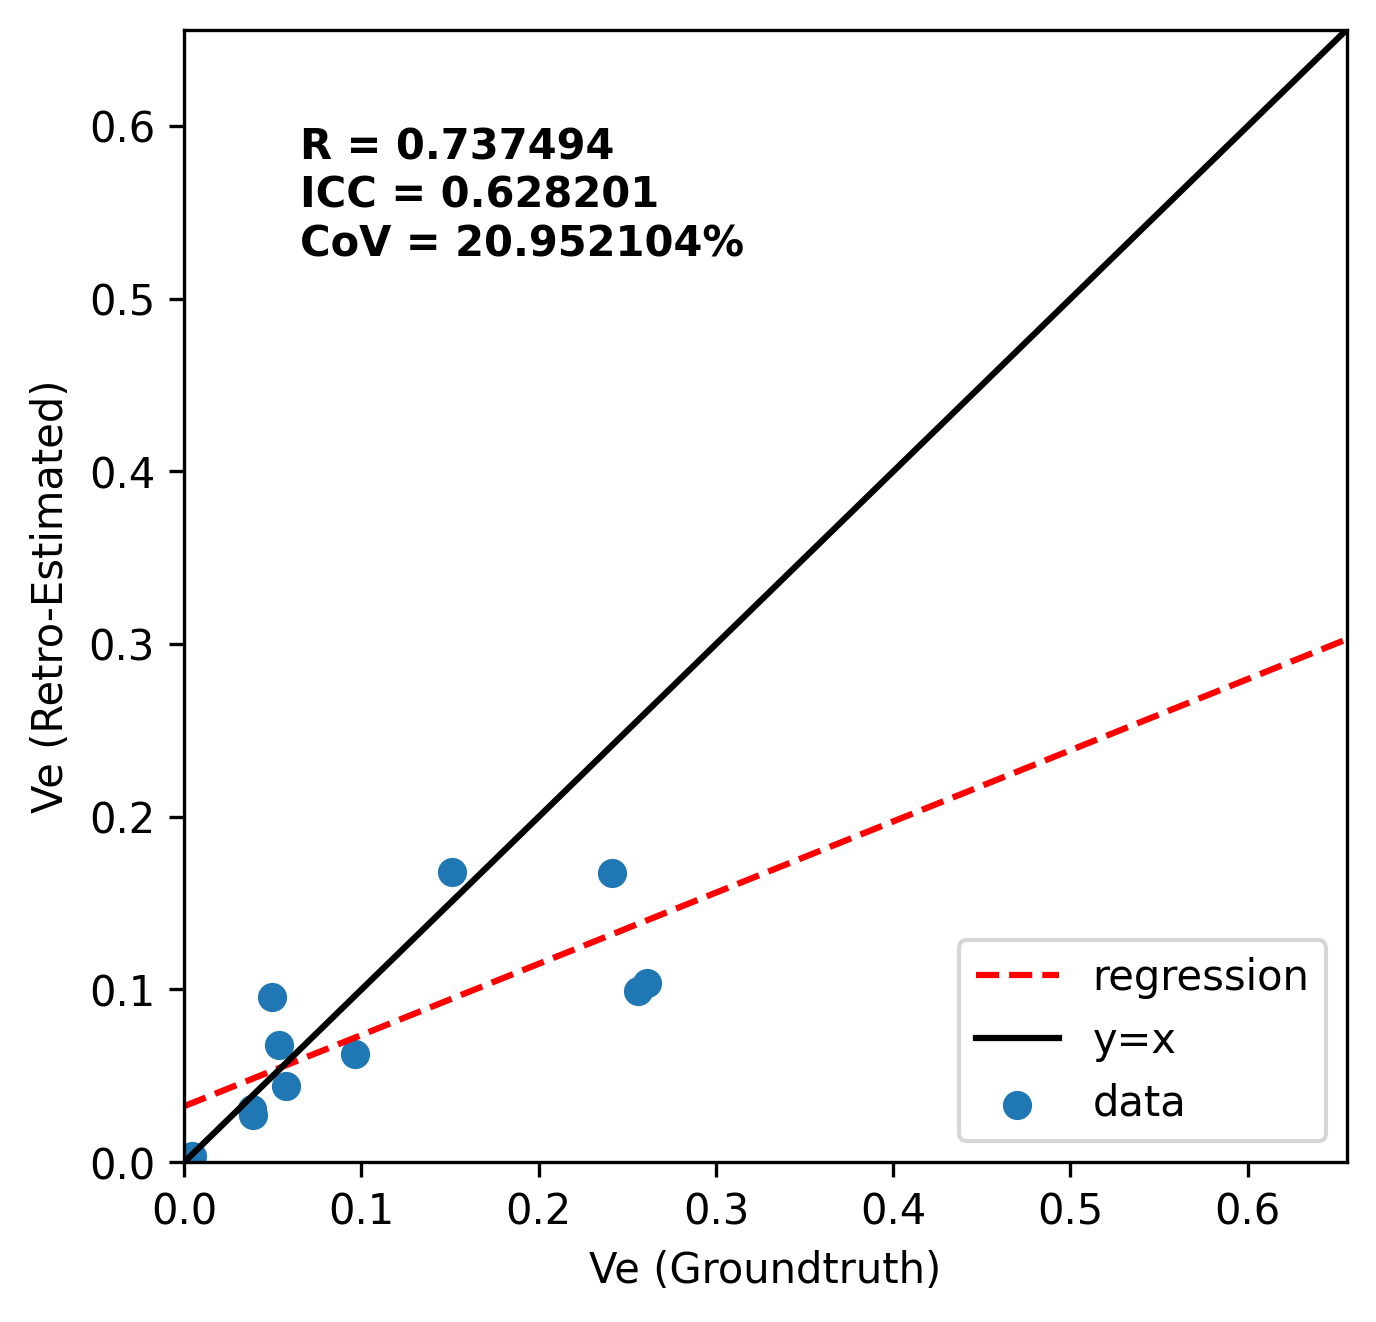

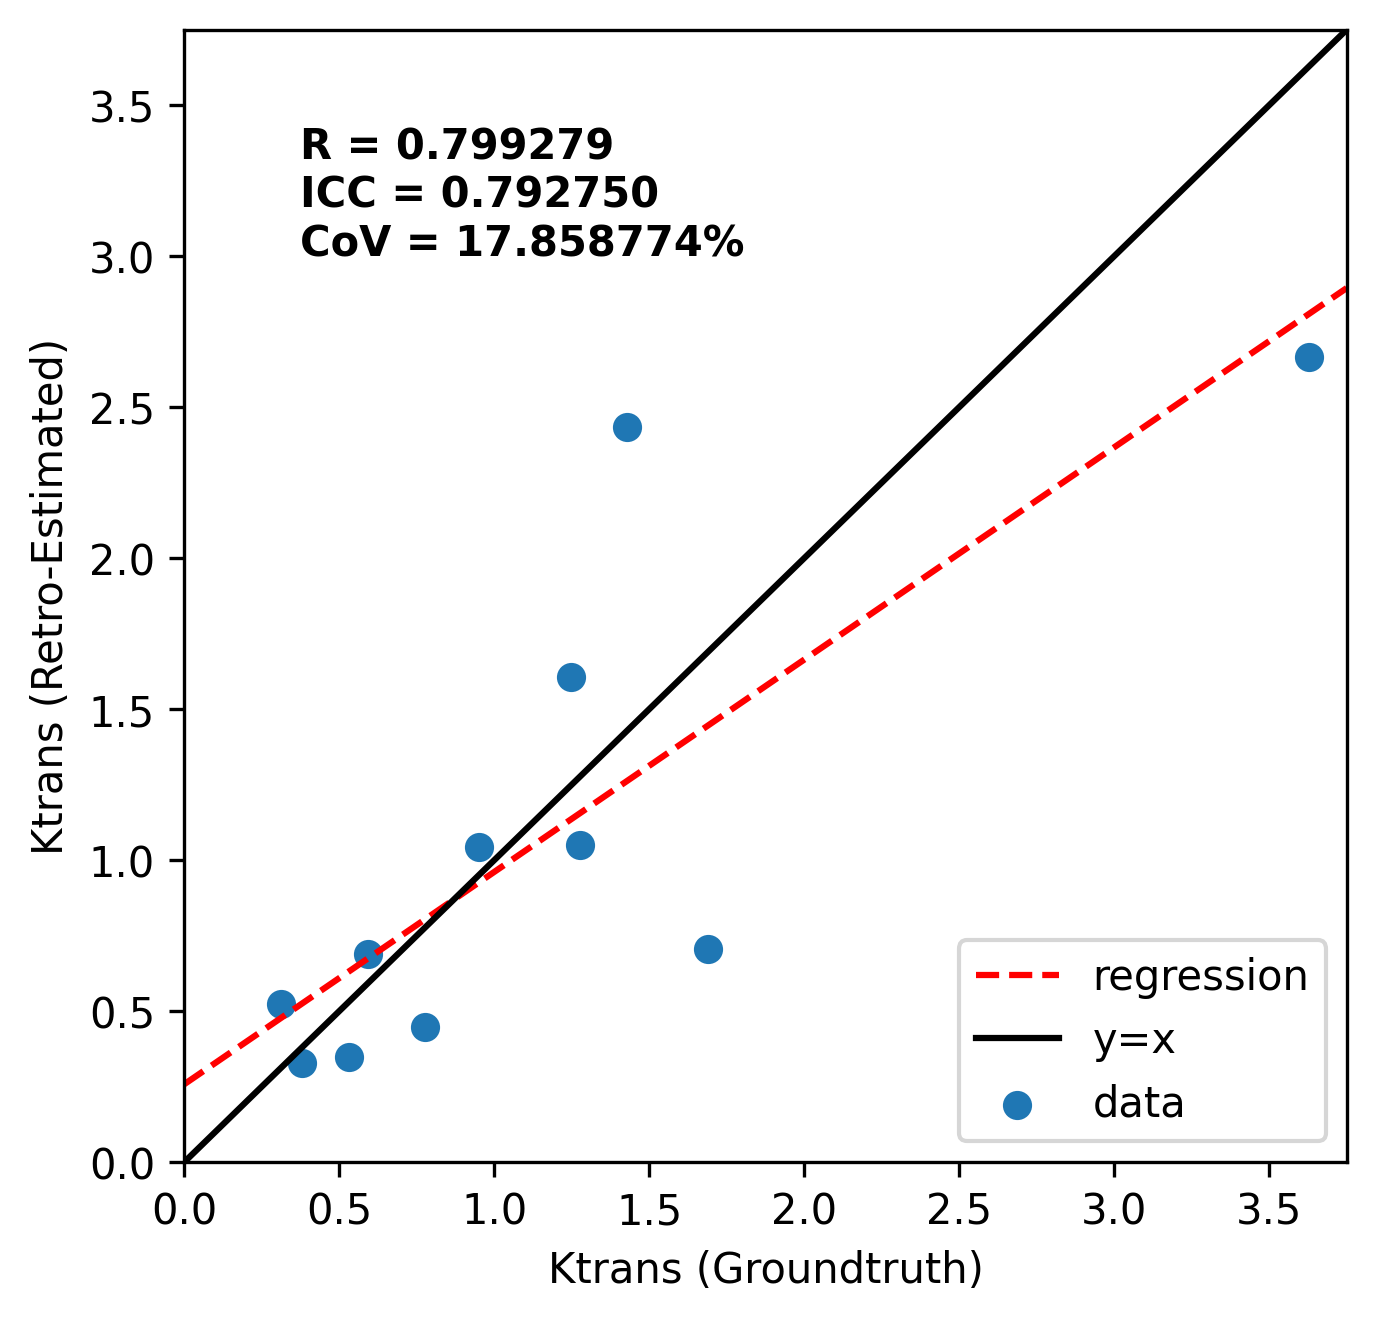

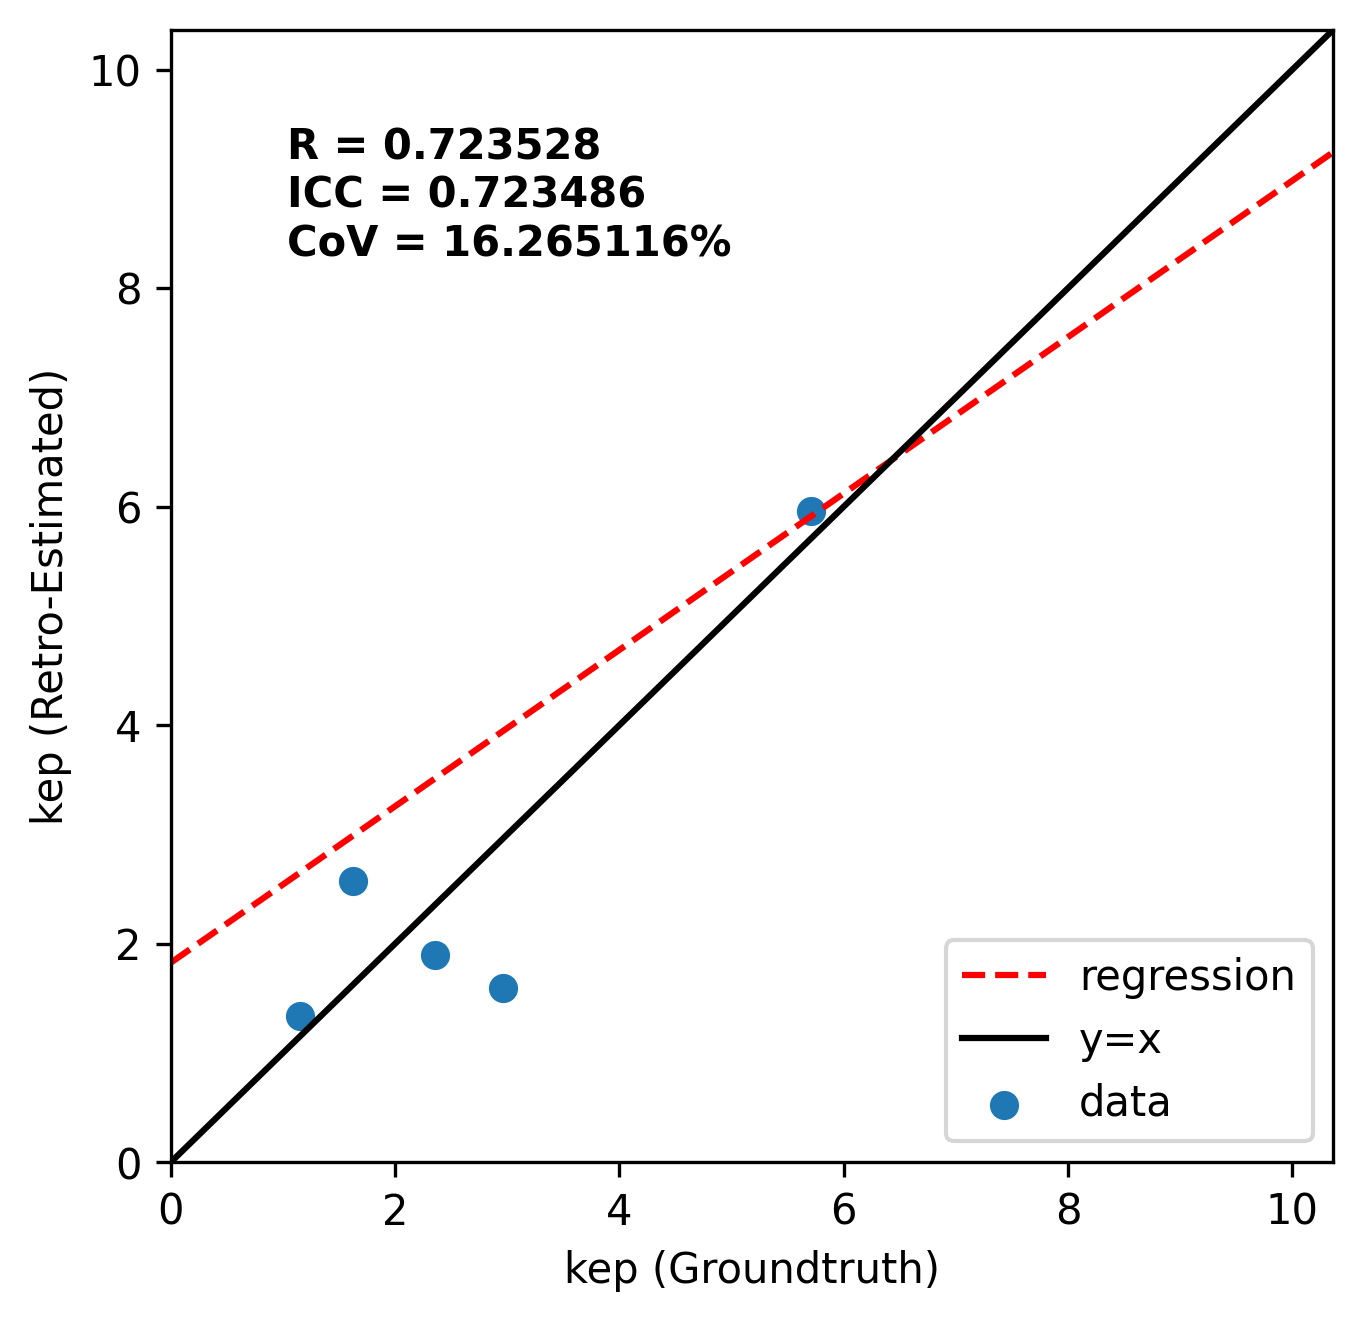

In [92]:
mode='do'
MyPlot(Y_test_contrast[:,2],Y_pred_contrast[:,2],["Ve (Groundtruth)","Ve (Retro-Estimated)"],np.max([Y_pred_tum[:,2],Y_test_tum[:,2]]),_dir,'Vp_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_contrast[:,0],Y_pred_contrast[:,0],["Ktrans (Groundtruth)","Ktrans (Retro-Estimated)"],np.max([Y_pred_tum[:,0],Y_test_tum[:,0]]),_dir,'Ktrans_tum_Tofts_refit_mPM',mode=mode)
MyPlot(Y_test_contrast[:,1],Y_pred_contrast[:,1],["kep (Groundtruth)","kep (Retro-Estimated)"],np.max([Y_pred_tum[:,1],Y_test_tum[:,1]]),_dir,'kep_tum_Tofts_refit_mPM',mode=mode)



In [28]:

data_dir = '/hdd1/chaowei/data/dce/pancreas_syn_linCA_wt_bd_figmakeTK_VARPRO/h5file'

"""
Save maps 
"""
def gen_inp_figmake(C_ts,C_bd):
    C_ts_lbl=C_ts
    C_bd_lbl =  C_bd
    norm_constant = np.max(C_bd_lbl)*(1-hct)

    # generate downsampled R1
    C_ts_ds,C_ts,bundle = gen_ds_R1(C_ts,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    # generate blood input 
    C_bd_ds,C_bd,bundle = gen_ds_R1(C_bd,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    # clip label 
    _,C_ts_lbl,_ = gen_ds_R1(C_ts_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    _,C_bd_lbl,_ = gen_ds_R1(C_bd_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False)
    # generate spike
    C_ts_itnpl = gen_inge_spike(C_ts_ds,bundle,OUT_DIM=OUT_DIM)
    C_bd_itnpl = gen_inge_spike(C_bd_ds,bundle,OUT_DIM=OUT_DIM)
    bd_temp = np.repeat(C_bd_itnpl.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
    bd_temp2 = np.repeat(C_bd_lbl.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
    
    X_valid_ts = C_ts_itnpl/norm_constant
    Y_valid_ts = C_ts_lbl/norm_constant
    X_valid_pl = bd_temp/norm_constant
    Y_valid_pl = bd_temp2/norm_constant
    
    return X_valid_ts,X_valid_pl,Y_valid_ts,Y_valid_pl

y_pred_pan, y_test_pan = np.zeros([0,3]),np.zeros([0,3])

for CV_SP in range(1):
    prefix_cv = "T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len%s-CV%s-RoQ-XAIFinput"%(str(LENGTH),str(CV_SP))
    """
    load data
    """
    mainfolder = data_dir
    
    """
    load weights
    """
    checkpoint_path = os.path.join("/hdd1/chaowei/dce-dl/checkpoint/T1W-XAIFinp",prefix_cv,"cp-{epoch:04d}.ckpt")
    checkpoint_dir = os.path.dirname(checkpoint_path)

    model_upsample.load_weights(tf.train.latest_checkpoint(os.path.abspath(checkpoint_dir))).assert_existing_objects_matched()
#     model_upsample = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Upsample_XAIF_wt_constraint_pancreas_cv00.h5')
    model_upsample.trainable = False

    """
    start testing
    """
    print('Start testing...')
    test_folder = os.path.join(mainfolder)
    test_id =os.listdir(test_folder)
    for i in range(len(test_id)): 
        h5file = h5py.File(os.path.join(test_folder,test_id[i]),'r')
        print('processing:',os.path.join(test_id[i])) 
        c_pl = np.array(h5file['c_pl_ori'],dtype=np.float32).transpose(1,0)
        c_pan =  np.concatenate((np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0),
                                 (1-hct)*np.array(h5file['c_pl_ori'],dtype=np.float32).transpose(1,0)),axis=0)
        num_pan = (np.array(h5file['c_pan'],dtype=np.float32).transpose(1,0)).shape[0]
        c_pan_itnpl,c_pl_itnpl,c_pan_ds,c_pl_ds = gen_inp_figmake(c_pan,c_pl)
        c_all_pred, _ = model_upsample.predict({"tissue_ds":c_pan_itnpl, "aorta_fs":c_pl_itnpl})
        c_pan_pred,c_pl_pred = c_all_pred[:num_pan,:],np.repeat((np.mean(c_all_pred[num_pan:,:],axis=0,keepdims=True))/(1-hct),num_pan,axis=0)
        c_pan_ds,c_pl_ds = c_pan_ds[:num_pan,:],np.repeat(np.mean(c_pl_ds[num_pan:,:],axis=0,keepdims=True),num_pan,axis=0)
        
        y_pred_pan = (permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_pred,"AIF":c_pl_pred})))
        y_test_pan = (permute_tf_tensor(model_deconv.predict({"Tissue":c_pan_ds,"AIF":c_pl_ds})))
            
        _dir = os.path.join("/hdd1/chaowei/dce-dl/result/",prefix)
        smart_mkdir(_dir)
        savemat(os.path.join(_dir,test_id[i] ),{"y_pred_pan":y_pred_pan,"y_test_pan":y_test_pan})
print('Finished Prediction.')



Start testing...
processing: PD_2210_z29_pan.mat
processing: HP_2287_z30_pan.mat
processing: PD_2166_z28_pan.mat
processing: PD_2166_z31_pan.mat
processing: PD_2127_z18_pan.mat
processing: PS_2300_z21_pan.mat
Finished Prediction.
